In [28]:
# Subtracting Trend Component: df = pd.read_csv('file.csv', parse_dates=['date'], index_col='date')

# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is montly_champagne_sales

## 02 - Load Data
Let's start by loading the time series of the challenge

In [1]:
import pandas as pd
df = pd.read_csv('data/monthly_champagne_sales.csv',index_col=0)

👉 Convert dataframe with datetime objects as index to make it look like this
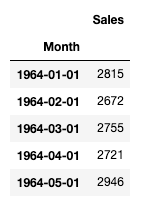

In [2]:
df.index = pd.to_datetime(df.index)
df.tail()

,Sales
Month,
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298
1972-08-01,1413
1972-09-01,5877


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

<AxesSubplot:xlabel='Month'>

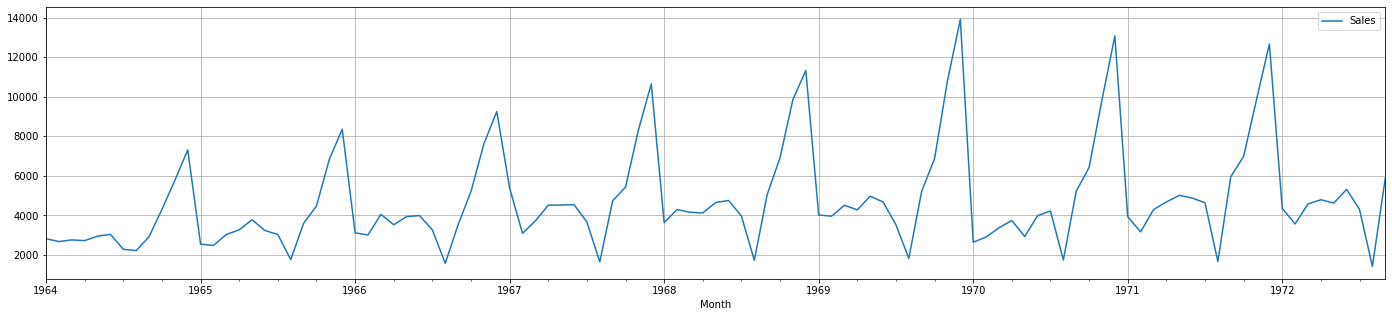

In [3]:
import matplotlib.pyplot as plt
df.plot(figsize=(24,5), grid='True')

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
out_addit = seasonal_decompose(df.Sales, model='additive', period=12, extrapolate_trend='freq') #, freq=24
out_multi = seasonal_decompose(df.Sales, model='multiplicative', period=12, extrapolate_trend='freq')

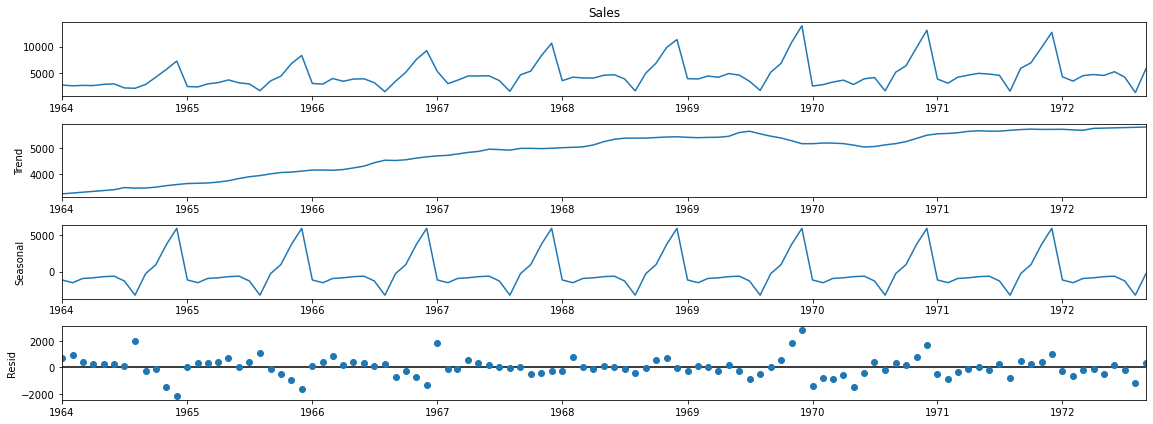

In [5]:
fig = out_addit.plot()
fig.set_size_inches(16,6)
plt.tight_layout();

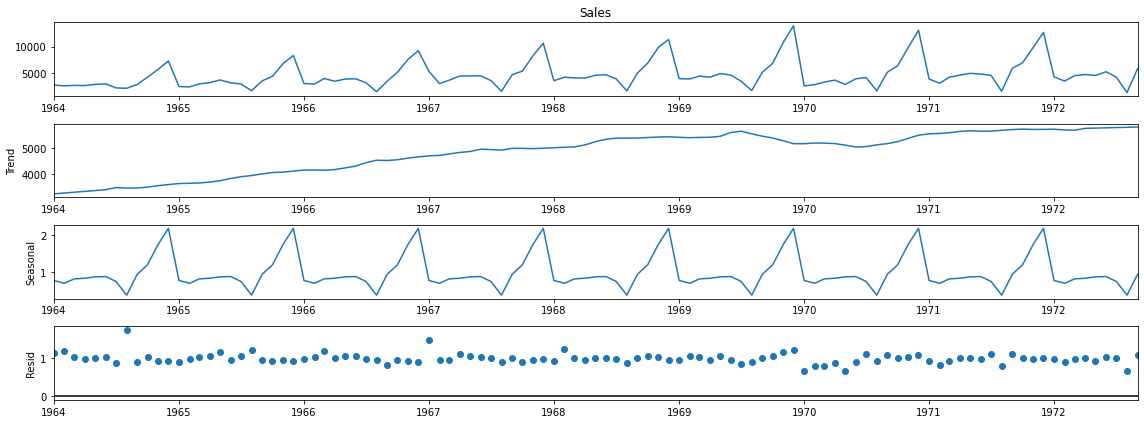

In [6]:
fig = out_multi.plot()
fig.set_size_inches(16,6)
plt.tight_layout();

👉 De-seasonalize this time serie using the decomposition of your choice

In [7]:
df['deseasonalized_addit'] = df.Sales.values - out_addit.seasonal #=out_addit.trend + out_addit.resid
df['deseasonalized_multi'] = df.Sales.values / out_multi.seasonal

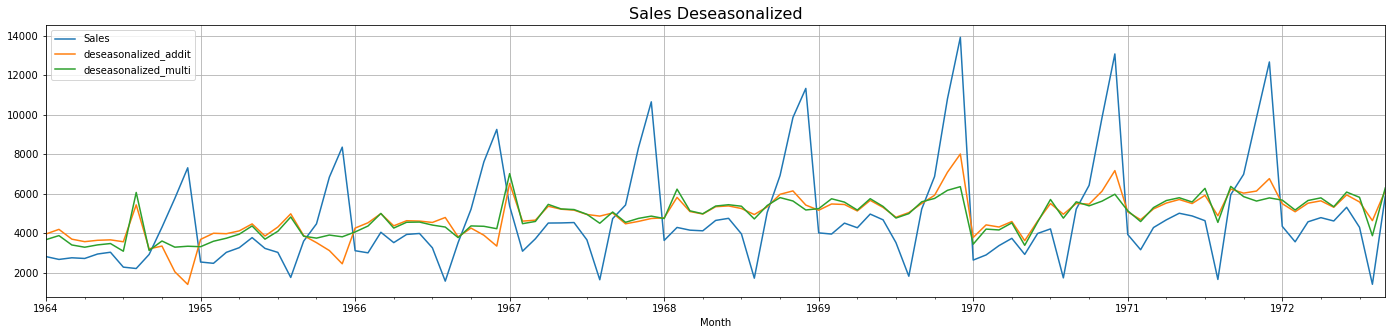

In [8]:
df.plot(figsize=(24,5), grid='True')
plt.title('Sales Deseasonalized', fontsize=16)
plt.show()

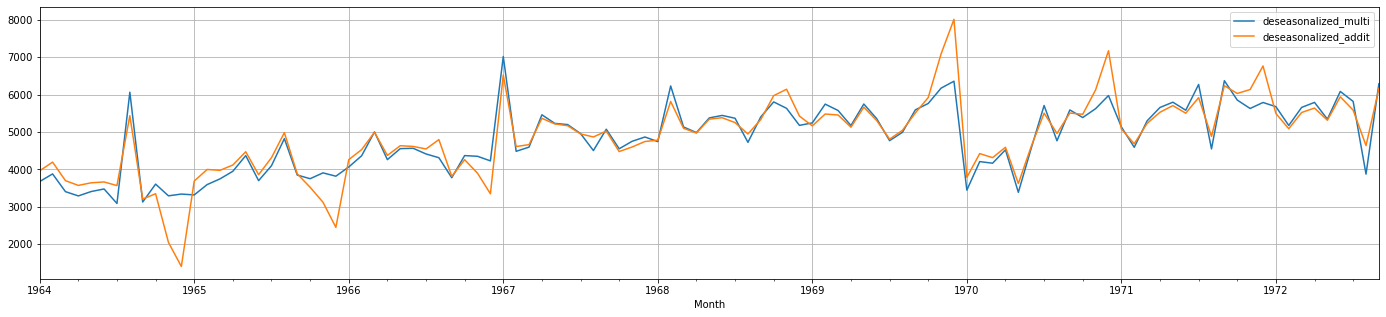

In [9]:
df[['deseasonalized_multi', 'deseasonalized_addit']].plot(figsize=(24,5), grid='True')
plt.show()

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

train = deseasonalized.loc[:'1969-12-01']
test = deseasonalized.loc['1970-01-01':]

In [10]:
df_train = df.loc[:'1969-12-01']
df_test = df.loc['1970-01-01':]

## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [11]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(y):
    result = adfuller(y)
    labels = ["ADF Test Statistic", 'p-value', "#Lags Used", "No. of observations"]
    for value, label in zip(result, labels):
        print(label,':',str(value))
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
        
    if result[1] <= 0.05:
        print("Strong Evidence against null hypothesis(Ho). Data has no unit root and is stationary")
    else:
        print("Weak Evidence against null hypothesis(H1), time series has a unit root indicating it is non-stationary ")

adfuller_test(df.Sales)

ADF Test Statistic : -1.8335930563276237
p-value : 0.3639157716602447
#Lags Used : 11
No. of observations : 93
Critical Values:
	1%: -3.502704609582561
	5%: -2.8931578098779522
	10%: -2.583636712914788
Weak Evidence against null hypothesis(H1), time series has a unit root indicating it is non-stationary 


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

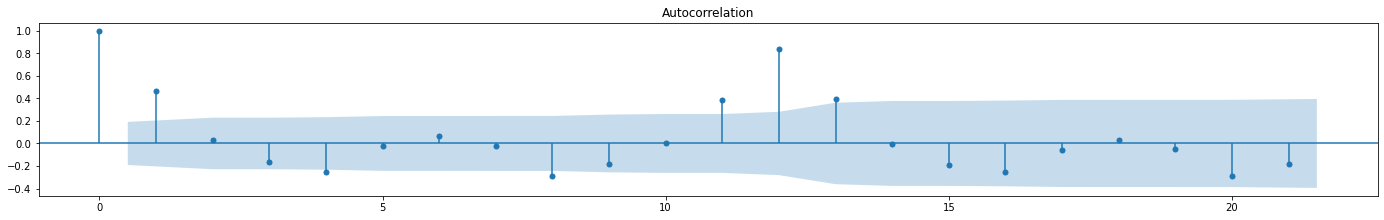

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(24,7))
ax1 = fig.add_subplot(211)
fig2 = plot_acf(df.Sales, ax=ax1)

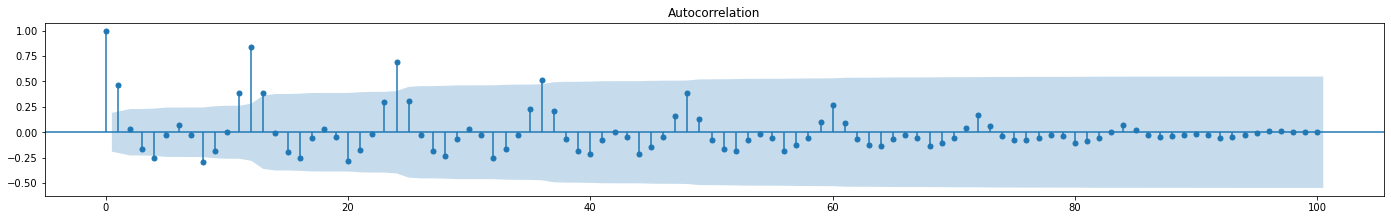

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(24,7))
ax1 = fig.add_subplot(211)
fig2 = plot_acf(df.Sales, ax=ax1, lags=100)

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

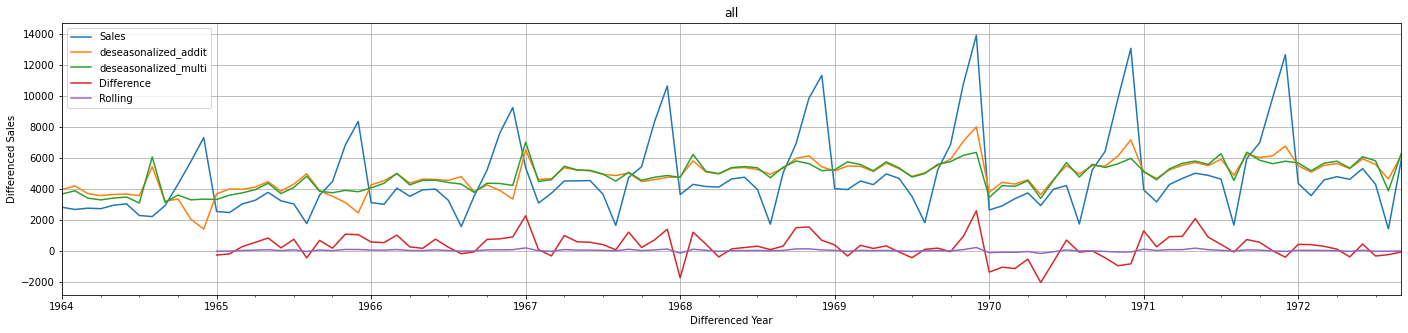

In [14]:
df["Difference"] = df["Sales"]- df["Sales"].shift(12)
#df["Rolling"] = df["Sales"].rolling(window = 12, center=False).mean()
df["Rolling"] = df["Sales"].rolling(window = 12, center=False).mean() - df["Sales"].rolling(window = 12, center=False).mean().shift()

df.plot(title='all',figsize=(24,5), grid='True');
#df[['Difference', "Rolling"]].plot(title='after rolling mean & differencing',figsize=(24,5), grid='True')
plt.legend(loc='best')
plt.xlabel('Differenced Year')
plt.ylabel('Differenced Sales')
plt.show(block=False)

In [15]:
#adfuller_test(df.Sales.diff(12).dropna())
adfuller_test(df.Difference.dropna())

ADF Test Statistic : -7.626619157213163
p-value : 2.060579696813685e-11
#Lags Used : 0
No. of observations : 92
Critical Values:
	1%: -3.503514579651927
	5%: -2.893507960466837
	10%: -2.583823615311909
Strong Evidence against null hypothesis(Ho). Data has no unit root and is stationary


In [16]:
adfuller_test(df.Rolling.dropna())

ADF Test Statistic : -7.626619157213172
p-value : 2.0605796968135808e-11
#Lags Used : 0
No. of observations : 92
Critical Values:
	1%: -3.503514579651927
	5%: -2.893507960466837
	10%: -2.583823615311909
Strong Evidence against null hypothesis(Ho). Data has no unit root and is stationary


☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

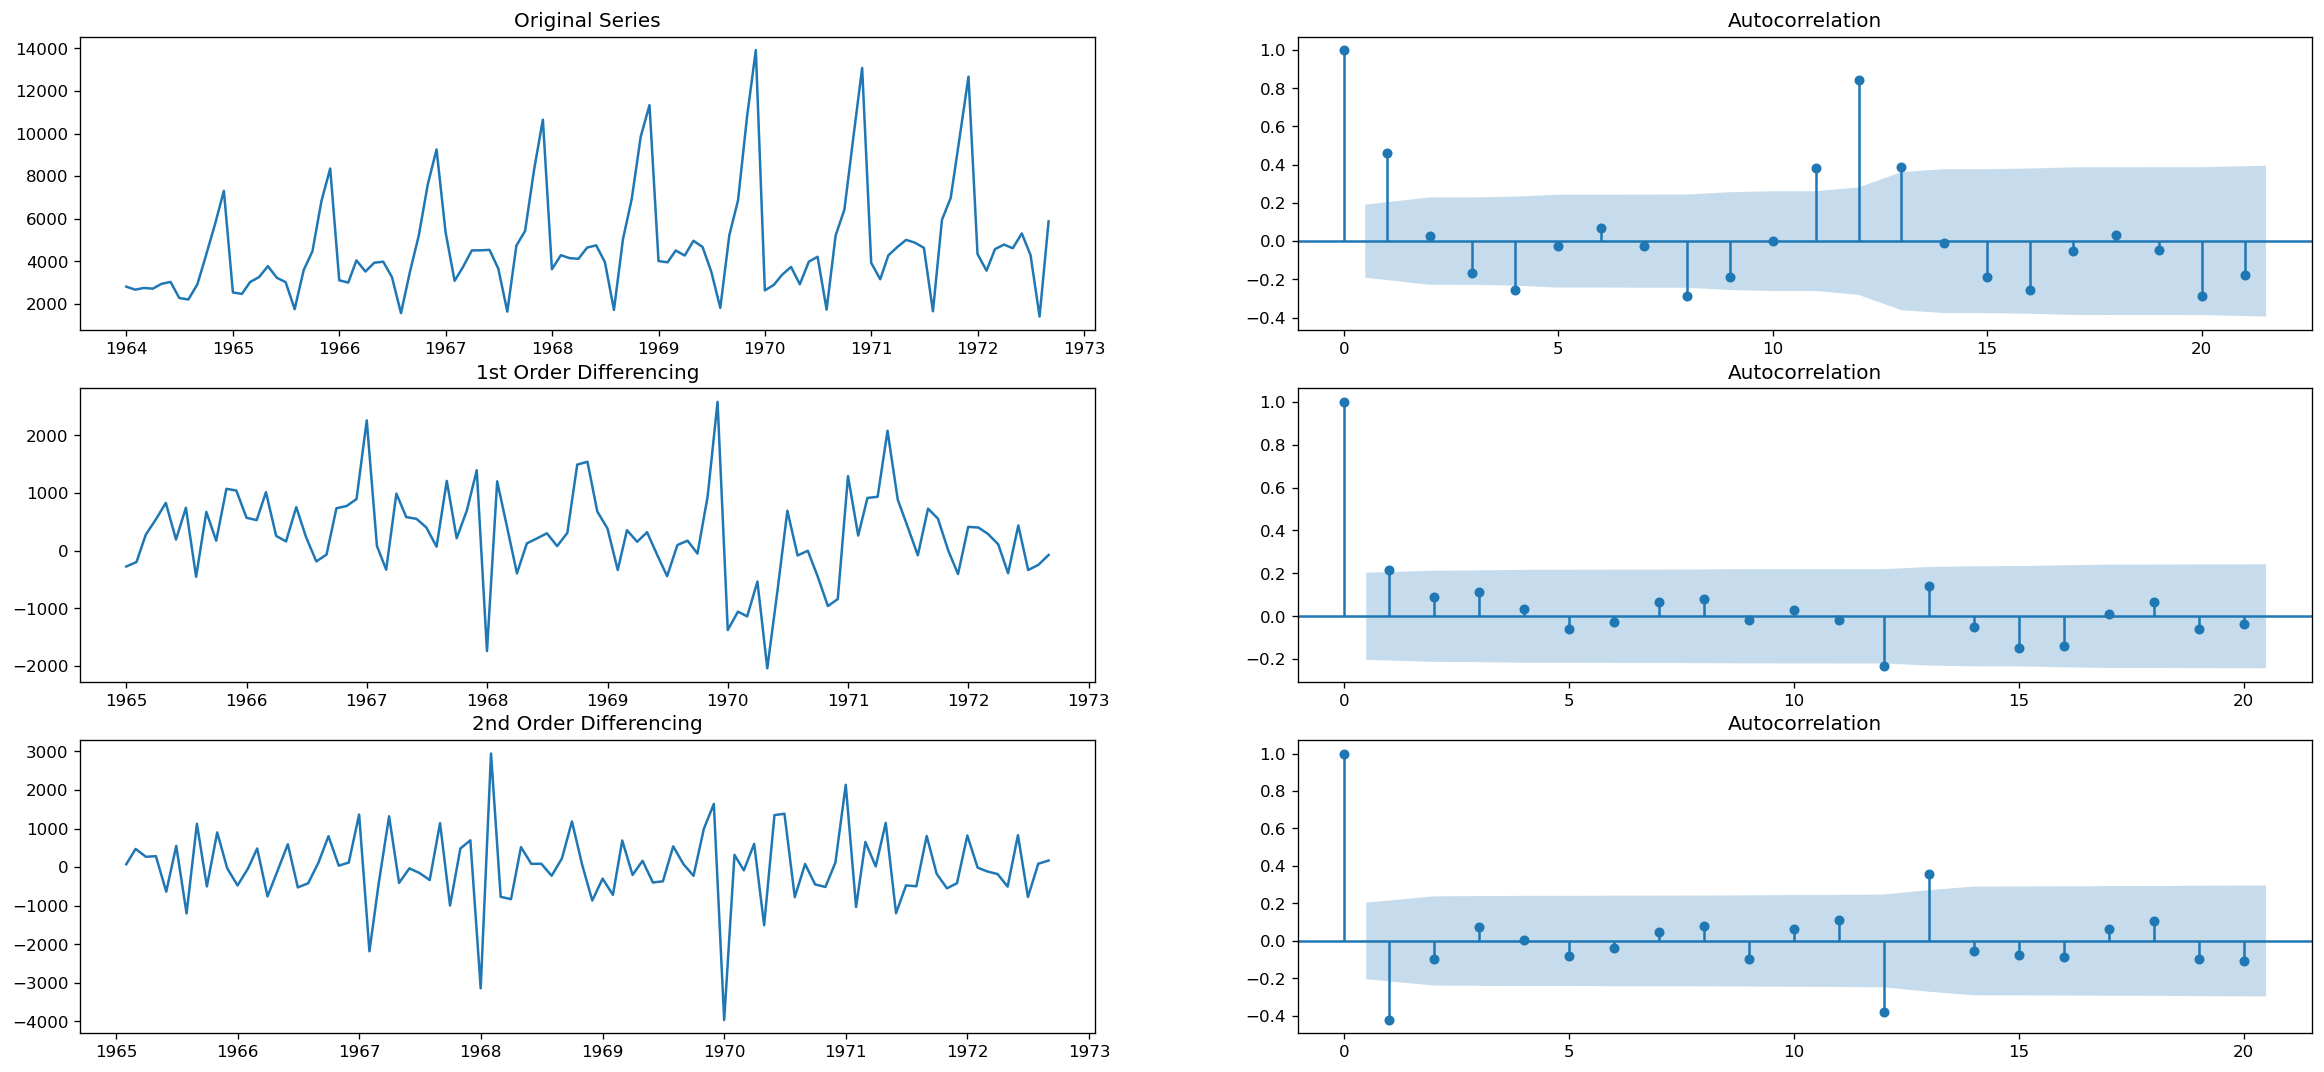

In [17]:
plt.rcParams.update({'figure.figsize':(24,11), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df.Sales); axes[0, 0].set_title('Original Series')
plot_acf(df.Sales, ax=axes[0, 1])

axes[1, 0].plot(df.Sales.diff(12)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Sales.diff(12).dropna(), ax=axes[1, 1]); 

axes[2, 0].plot(df.Sales.diff(12).diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Sales.diff(12).diff().dropna(), ax=axes[2, 1])

plt.show()

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

In [18]:
#adfuller_test(df.Difference.diff().dropna())
adfuller_test(df.Sales.diff(12).diff().dropna())

ADF Test Statistic : -4.427713497307481
p-value : 0.0002650462849293715
#Lags Used : 11
No. of observations : 80
Critical Values:
	1%: -3.5148692050781247
	5%: -2.8984085156250003
	10%: -2.58643890625
Strong Evidence against null hypothesis(Ho). Data has no unit root and is stationary


### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

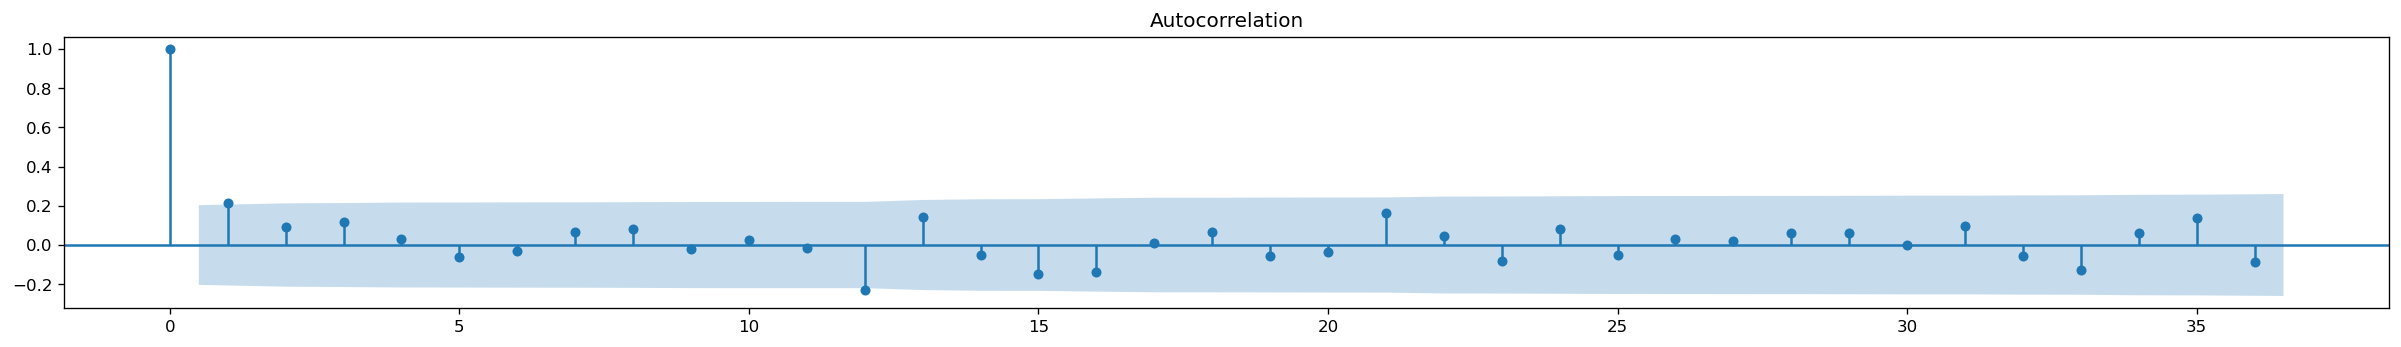

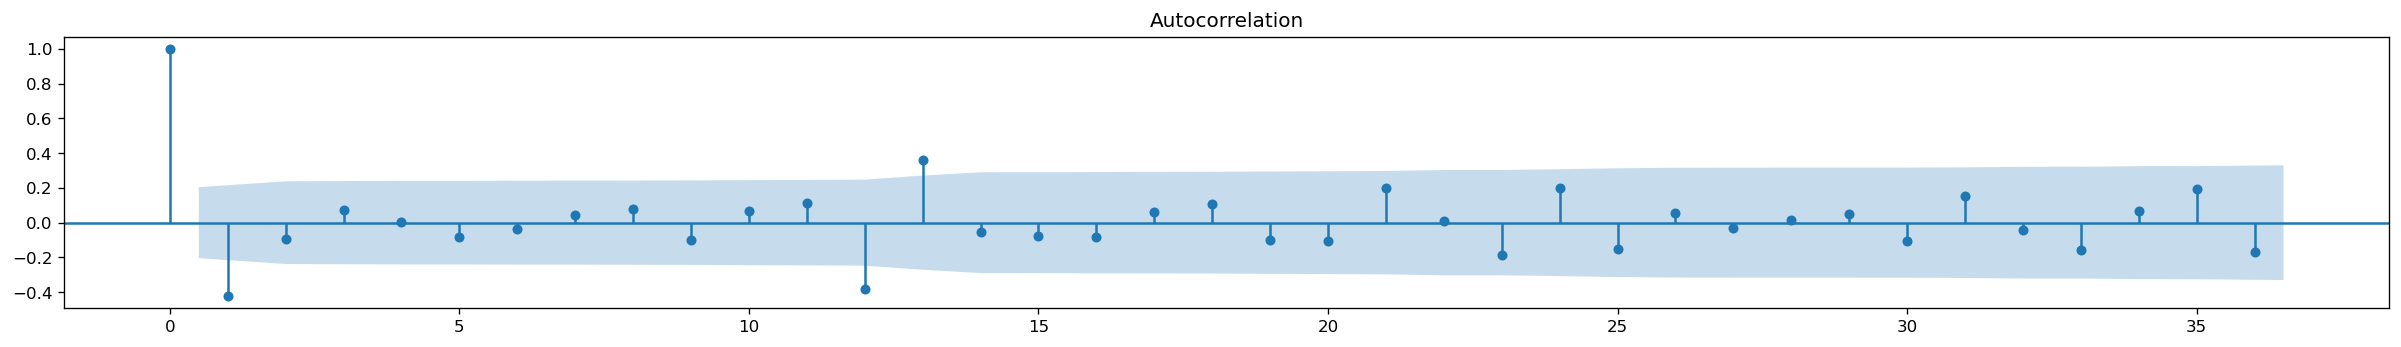

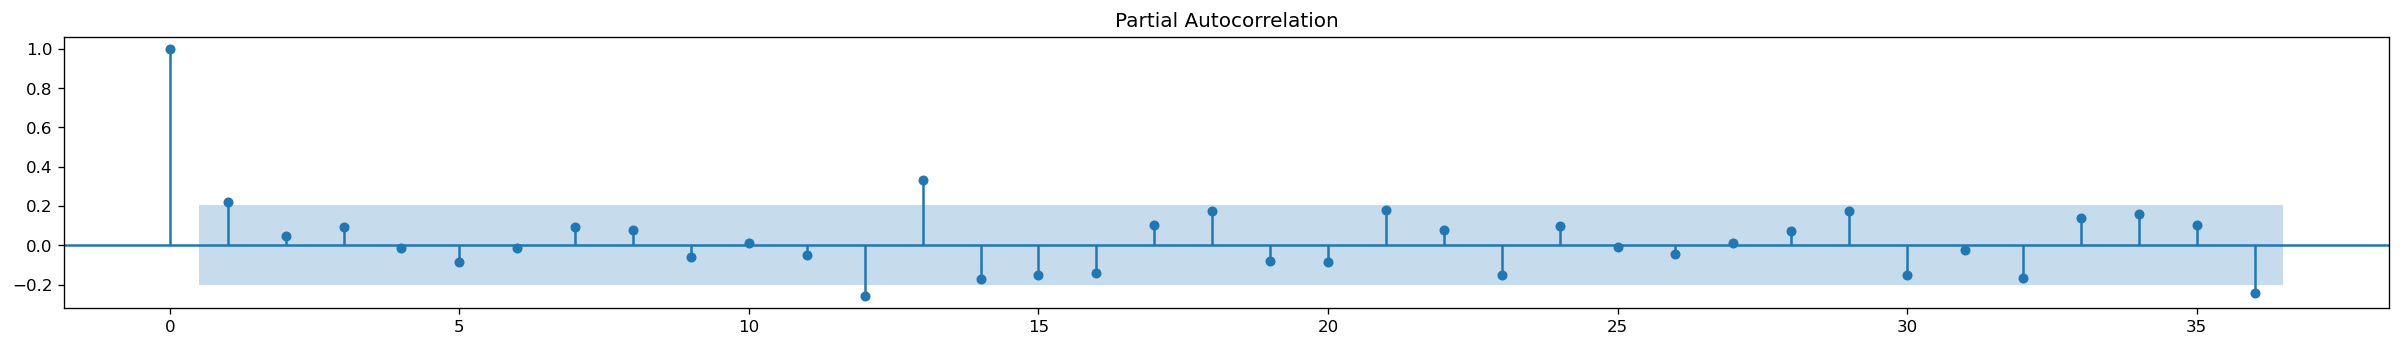

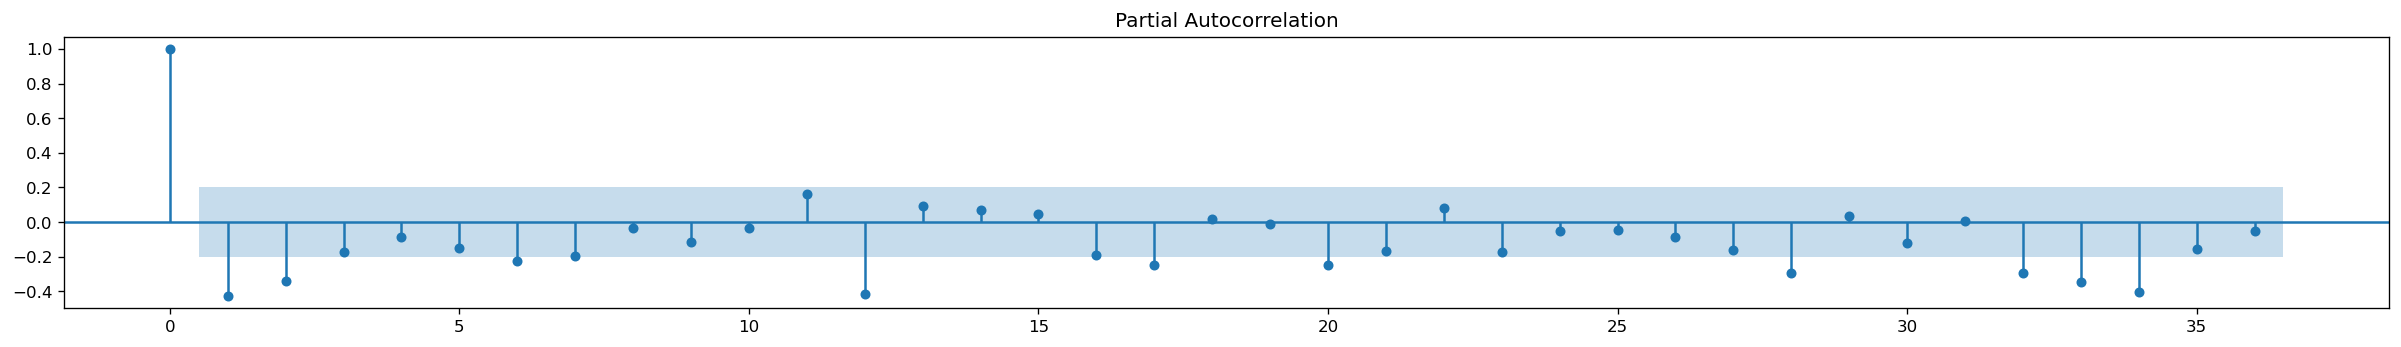

In [19]:
plt.rcParams.update({'figure.figsize':(25,3)})
plot_acf(df.Sales.diff(12).dropna(), lags=36); 
plot_acf(df.Sales.diff(12).diff().dropna(), lags=36);
plot_pacf(df.Sales.diff(12).dropna(), lags=36);
plot_pacf(df.Sales.diff(12).diff().dropna(), lags=36);
plt.show()

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [20]:
import pmdarima as pm

model = pm.auto_arima(df_train.Sales, start_p=0, start_q=0, test='adf', max_p=5, max_q=5,
                      m=12, d=0, seasonal=True, start_P=0, max_P=5, start_Q=0, max_Q=5, D=1,
                      njobs=-1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.07 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.20 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.111 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood 

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

👇 Run the cell below to plot your predictions against reality

In [21]:
prediction, confidence = model.predict(n_periods=len(df_test), return_conf_int=True)
central = pd.Series(prediction, index = df_test.index)
lower = pd.Series(confidence[:, 0], index = df_test.index)
upper = pd.Series(confidence[:, 1], index = df_test.index)

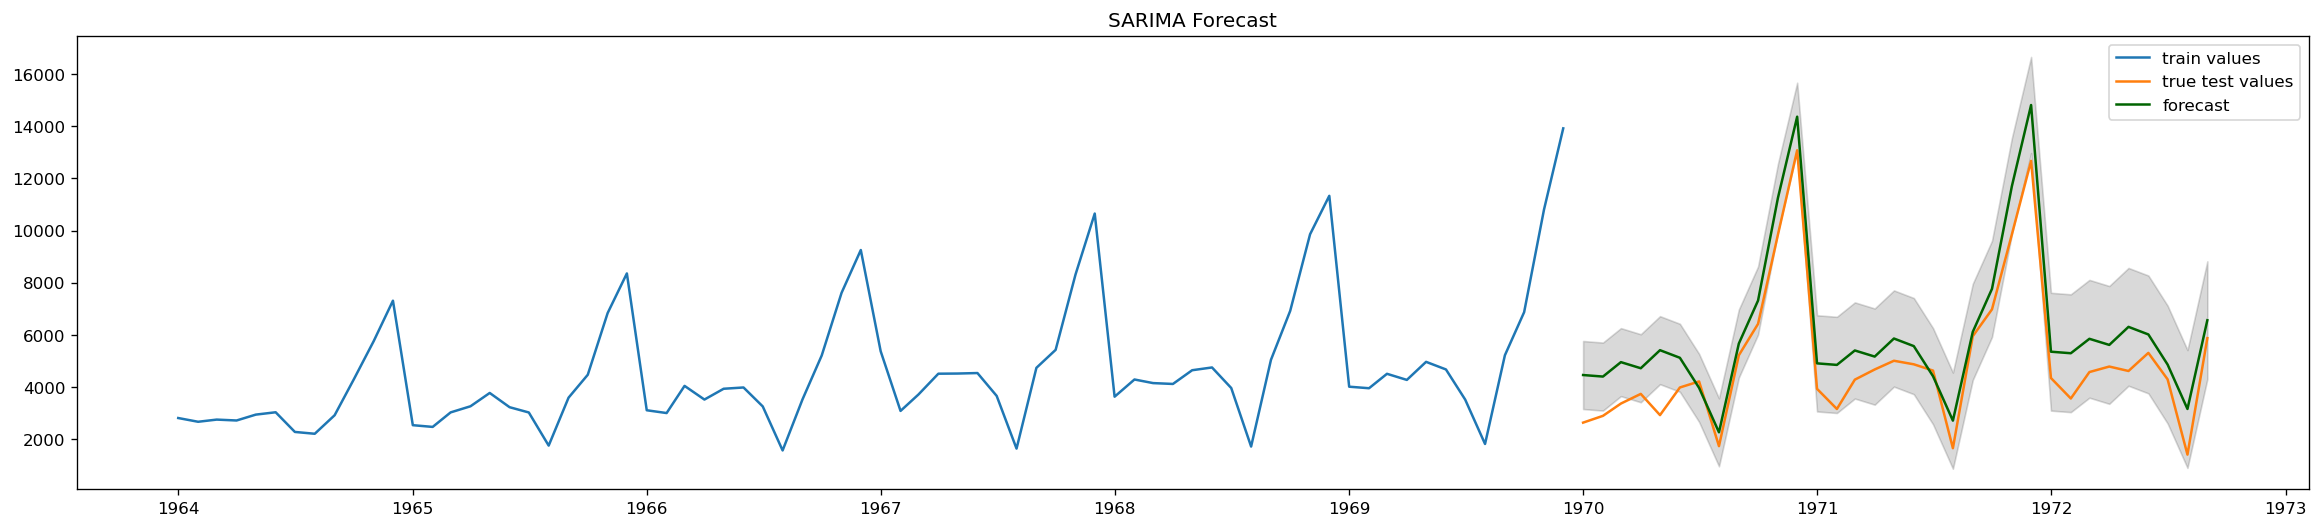

In [22]:
plt.figure(figsize=(24,5))
plt.plot(df_train.Sales, label = "train values")
plt.plot(df_test.Sales, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, lower, upper, color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend(loc='best')
plt.show(block=False)

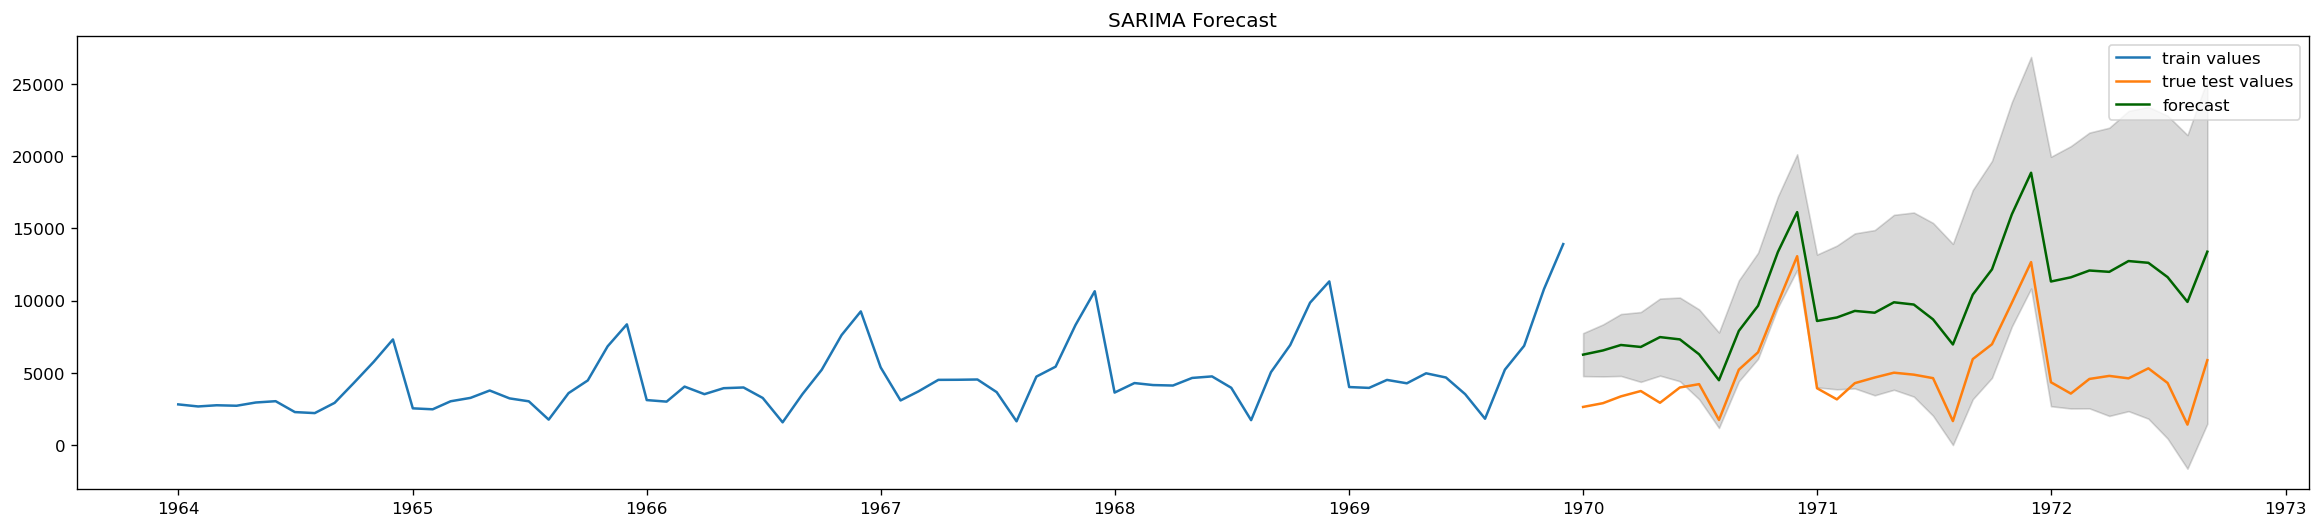

In [23]:
model = pm.ARIMA((1,1,0), (1,1,0,12), trend='c',)
model = model.fit(df_train.Sales, n_periods=12)

prediction, confidence = model.predict(n_periods=len(df_test), return_conf_int=True)
central = pd.Series(prediction, index = df_test.index)
lower = pd.Series(confidence[:, 0], index = df_test.index)
upper = pd.Series(confidence[:, 1], index = df_test.index)

plt.figure(figsize=(24,5))
plt.plot(df_train.Sales, label = "train values")
plt.plot(df_test.Sales, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, lower, upper, color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend(loc='best')
plt.show(block=False)

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

#### Manual construction of SARIMA model

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

df_train = df_train.asfreq('MS')
model = SARIMAX(df_train.Sales, order=(0,0,0), seasonal_order=(0,1,0,12), trend=[0,1,2,-5],
                enforce_stationarity=False, enforce_invertibility=False, measurement_error=False)

sarima_results = model.fit()                  #sarima_results.specification
sarima_pred = sarima_results.get_forecast(33) #df_test.shape[0] or len(df_test)
sarima_mean = sarima_pred.predicted_mean      # Extract predicted mean attribute

print(sarima_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         23.4098      8.515      2.749      0.006       6.721      40.099
trend.2       -0.2608      0.147     -1.778      0.075      -0.548       0.027
sigma2      4.543e+05   6.31e+04      7.203      0.000    3.31e+05    5.78e+05


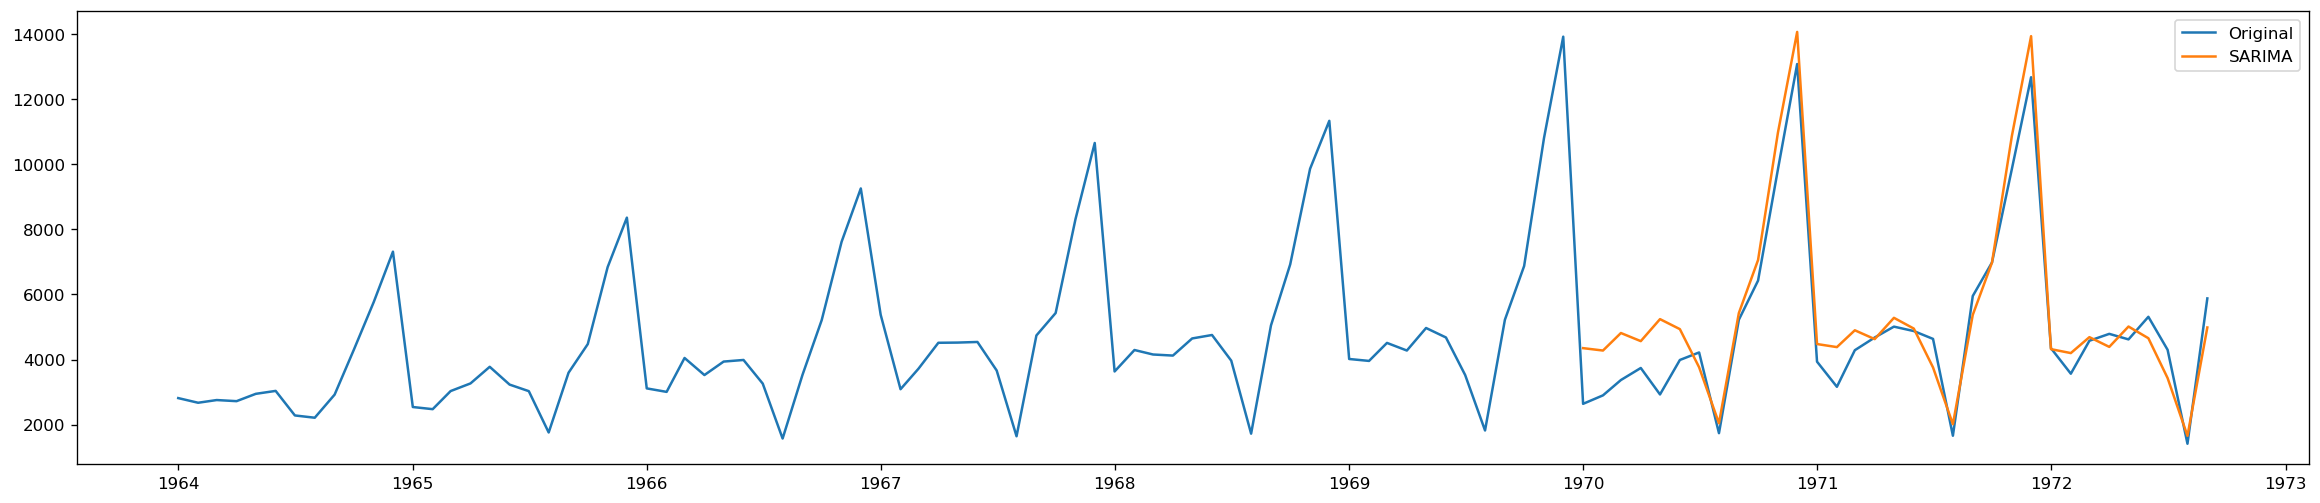

In [25]:
plt.figure(figsize=(24,5))
plt.plot(df.Sales, label='Original');
plt.plot(df_test.index, sarima_mean, label='SARIMA');
plt.legend()
plt.show()

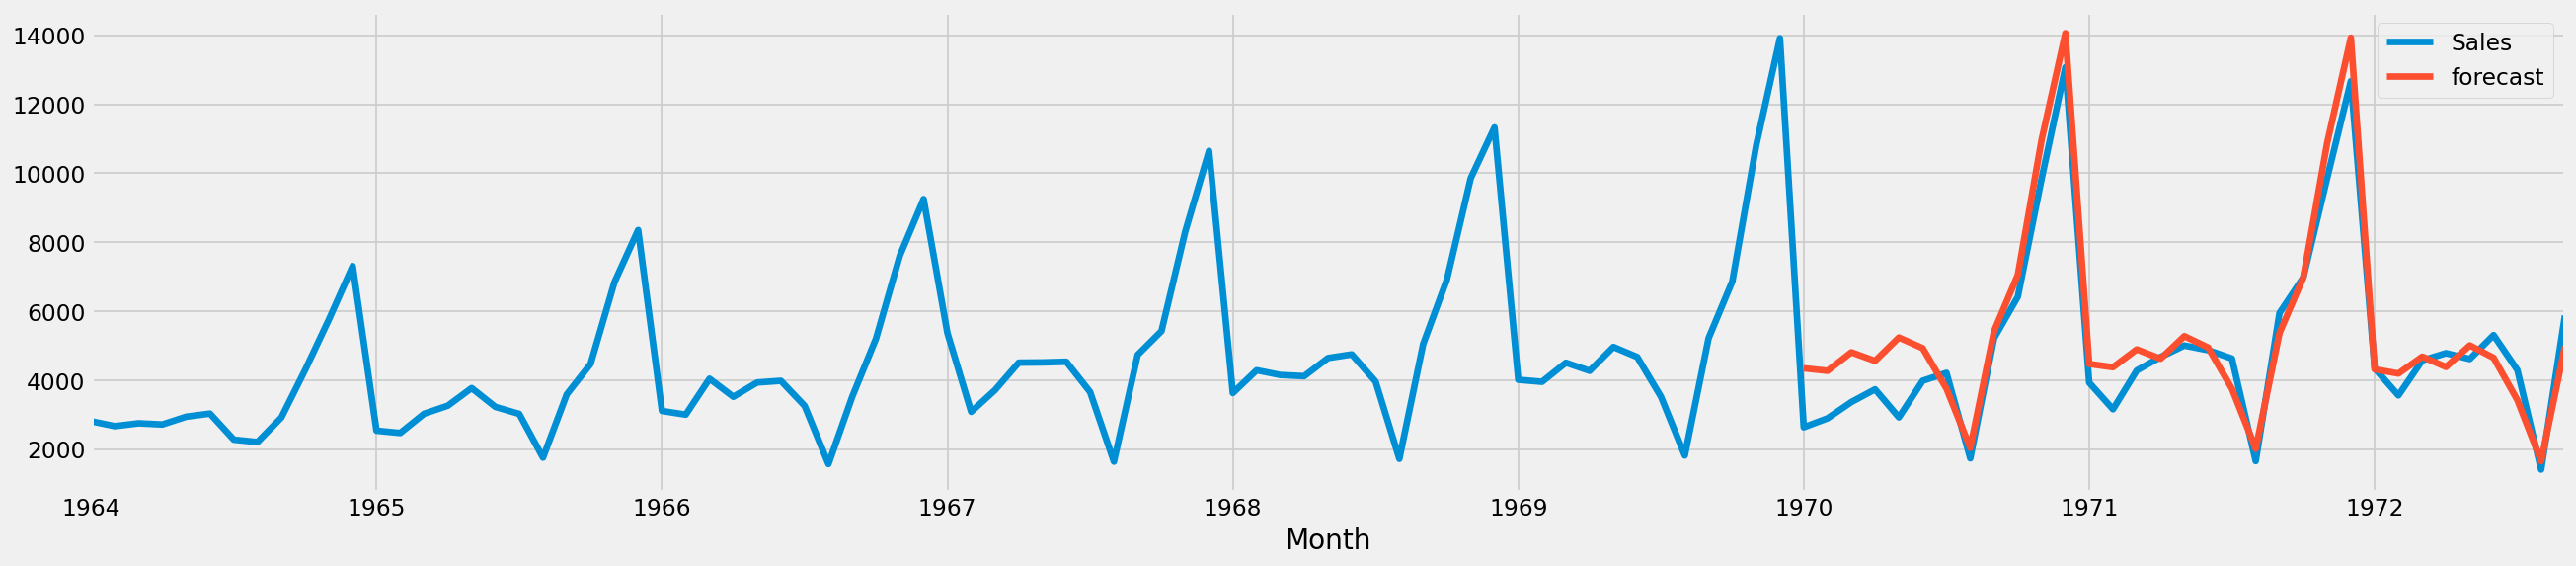

In [26]:
plt.rcParams['figure.figsize'] = (24,5)
plt.style.use('fivethirtyeight')

df['forecast'] = sarima_results.predict(start=72,end=104, dynamic=True)
df[['Sales','forecast']].plot(figsize=(24,5))
plt.show()

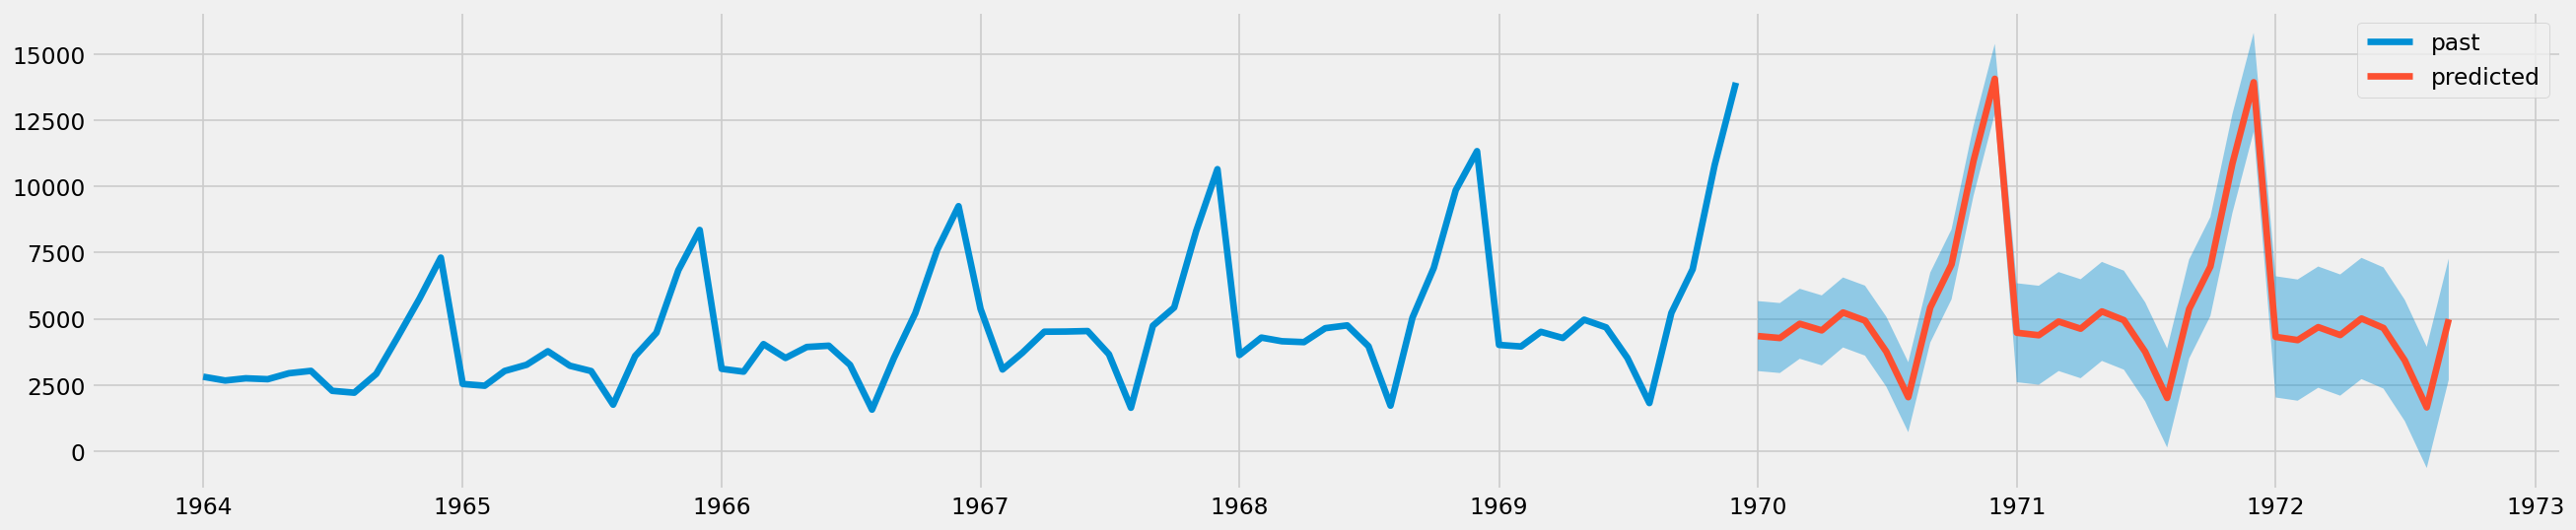

In [27]:
conf_int = sarima_pred.conf_int()        # Calculate the confidence intervals
dates = sarima_mean.index                # Extract the forecast dates

plt.figure()
plt.plot(df_train.index, df_train.Sales, label='past'); # Plot past levels
plt.plot(dates, sarima_mean, label='predicted'); # Plot prediction means as line
plt.fill_between(dates, conf_int.loc[:, 'lower Sales'], conf_int.loc[:, 'upper Sales'], alpha=0.4);
plt.legend();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


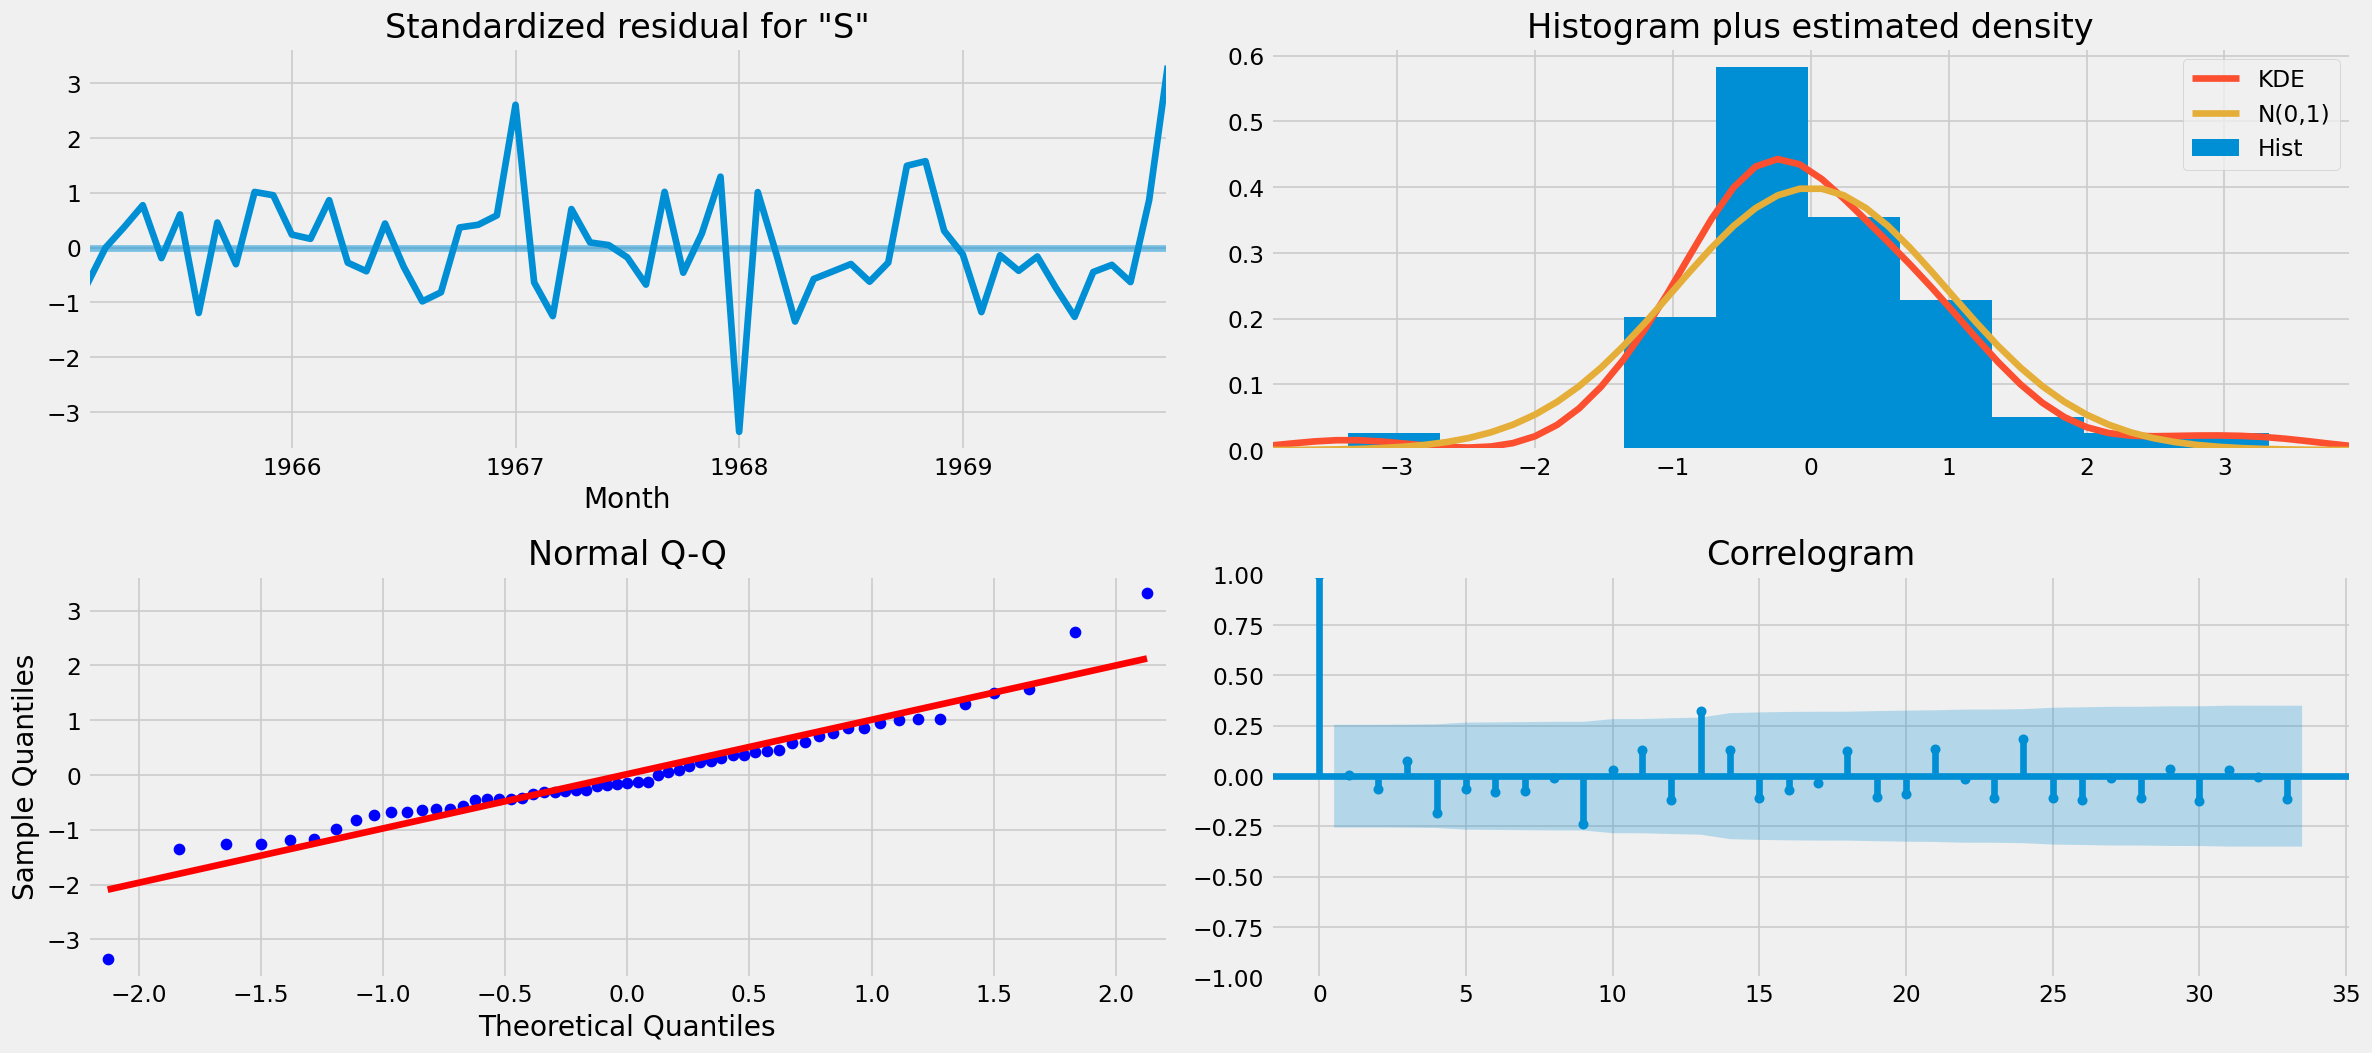

In [28]:
sarima_results.plot_diagnostics(figsize=(20, 11),lags=33);
plt.tight_layout();

#### Forecast prediction with ExponentialSmoothing

In [29]:
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

y = np.asarray(df_train.Sales)
hw = ExponentialSmoothing(y, seasonal_periods=12, trend='additive', seasonal='additive').fit()
hw_pred = hw.forecast(33)

hw.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


{'smoothing_level': 0.005520539128692676,
 'smoothing_trend': 0.00011239692100724127,
 'smoothing_seasonal': 0.8790241551975333,
 'damping_trend': nan,
 'initial_level': 3461.0365984115906,
 'initial_trend': 36.2497115344041,
 'initial_seasons': array([ -770.93335444,  -915.39525329,  -830.95734663,  -865.63616707,
         -640.90874026,  -556.38685839, -1309.2363703 , -1388.87902975,
         -673.45907505,   701.02977358,  2167.76194335,  3713.63711187]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

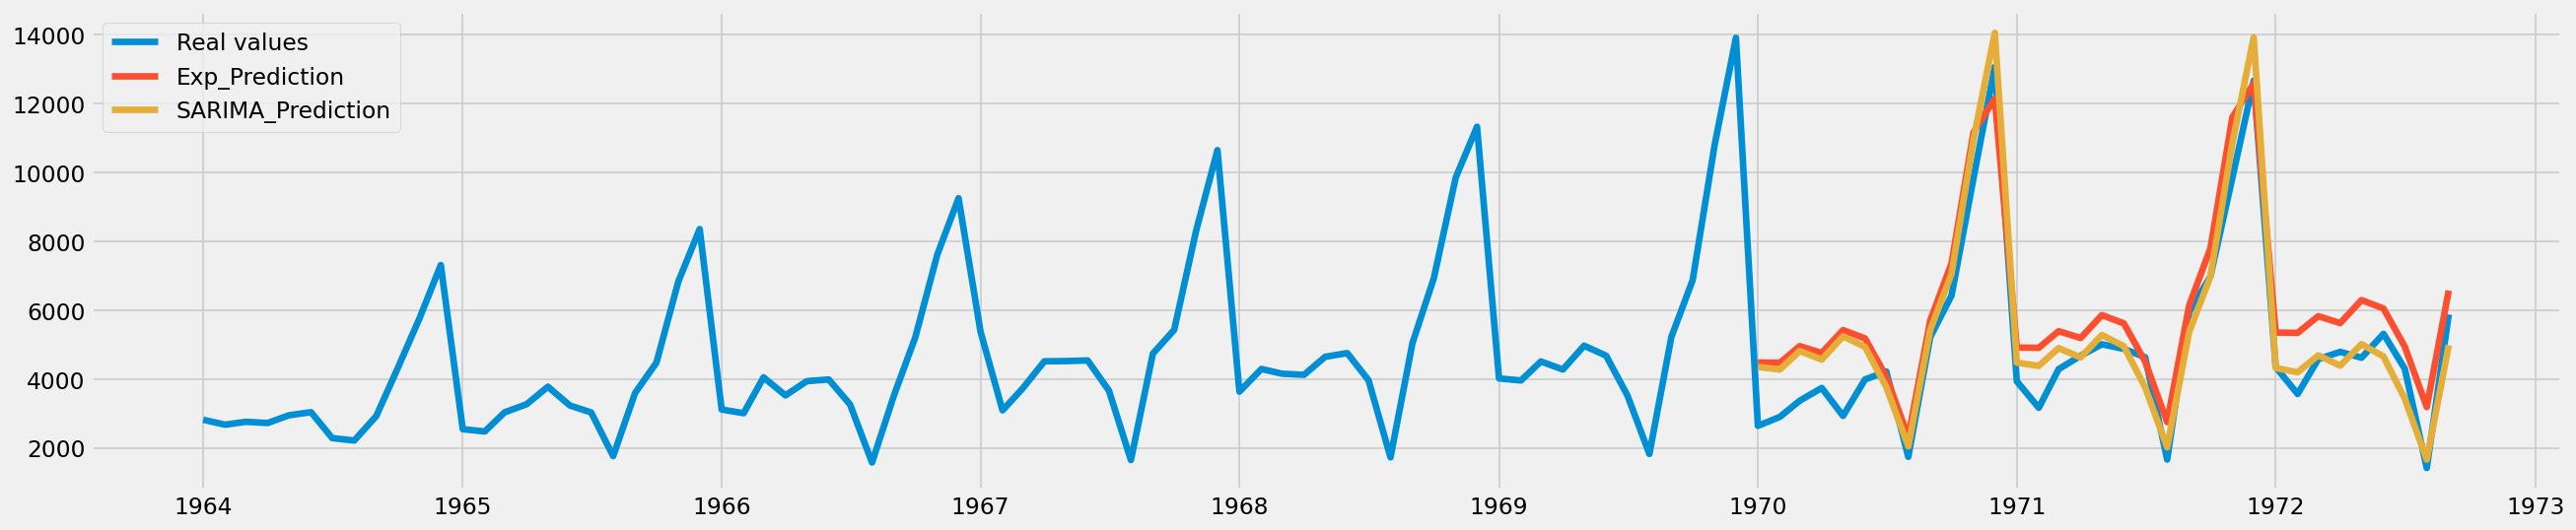

In [31]:
plt.figure(figsize=(24,5))
plt.plot(df.index, df.Sales, label='Real values');
plt.plot(df_test.index, hw_pred, label='Exp_Prediction')
plt.plot(dates, sarima_mean, label='SARIMA_Prediction');
plt.legend();

# OPTIONAL - Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [32]:
data = pd.read_csv('data/monthly_champagne_sales.csv')
data.Month = pd.to_datetime(data.Month)

In [33]:
for i in range(1, 25):    # Adding lagged values (of target variable) from 1 steps to 24
    data["lag_{}".format(i)] = data.Sales.shift(i)
    
df = data.dropna(axis=0).reset_index(drop=True)
df_train, df_test = df[df.Month < '1970-01-01'], df[df.Month >= '1970-01-01']

In [34]:
test_indexes = df_test.index
test_indexes

Int64Index([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
            65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
           dtype='int64')

In [35]:
X = df.drop(['Sales', 'Month'], axis=1)
y = df.Sales

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

In [36]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(max_depth=5, random_state=10)

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [37]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [38]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [39]:
print('Mean Absolute Prediction Error MAPE')
results[2]

Mean Absolute Prediction Error MAPE


0.1813065238785999

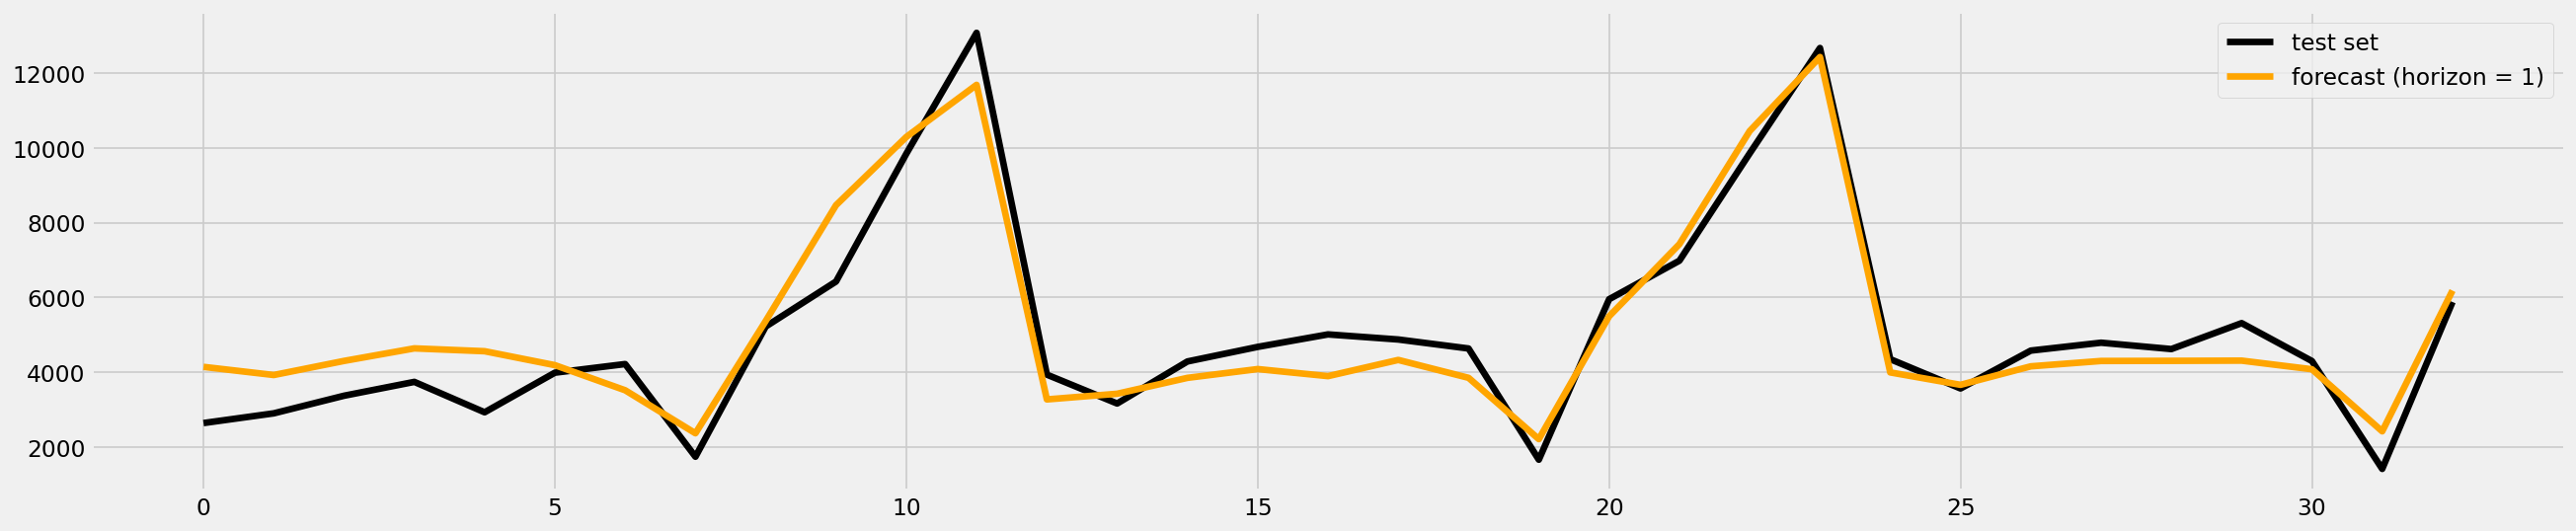

In [40]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [41]:
# Extract the trend using a well chosen moving average

In [42]:
data = pd.read_csv('data/monthly_champagne_sales.csv')
data.Month = pd.to_datetime(data.Month)

In [43]:
for i in range(1, 25):    # Adding lagged values (of target variable) from 1 steps to 24
    data["lag_{}".format(i)] = data.Sales.shift(i)

data["Rolling_12"] = data["Sales"].rolling(window = 12, center=False).mean()
data["Rolling_3"] = data["Sales"].rolling(window = 3, center=False).mean()
data["Rolling_2"] = data["Sales"].rolling(window = 2, center=False).mean()

df = data.dropna(axis=0).reset_index(drop=True)
df_train, df_test = df[df.Month < '1970-01-01'], df[df.Month >= '1970-01-01']

In [44]:
test_indexes = df_test.index
X = df.drop(['Sales', 'Month'], axis=1)
y = df.Sales

In [45]:
random_forest = RandomForestRegressor(max_depth=5, random_state=0)

In [46]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [47]:
print('Mean Absolute Prediction Error MAPE')
results[2]

Mean Absolute Prediction Error MAPE


0.16834834135074433

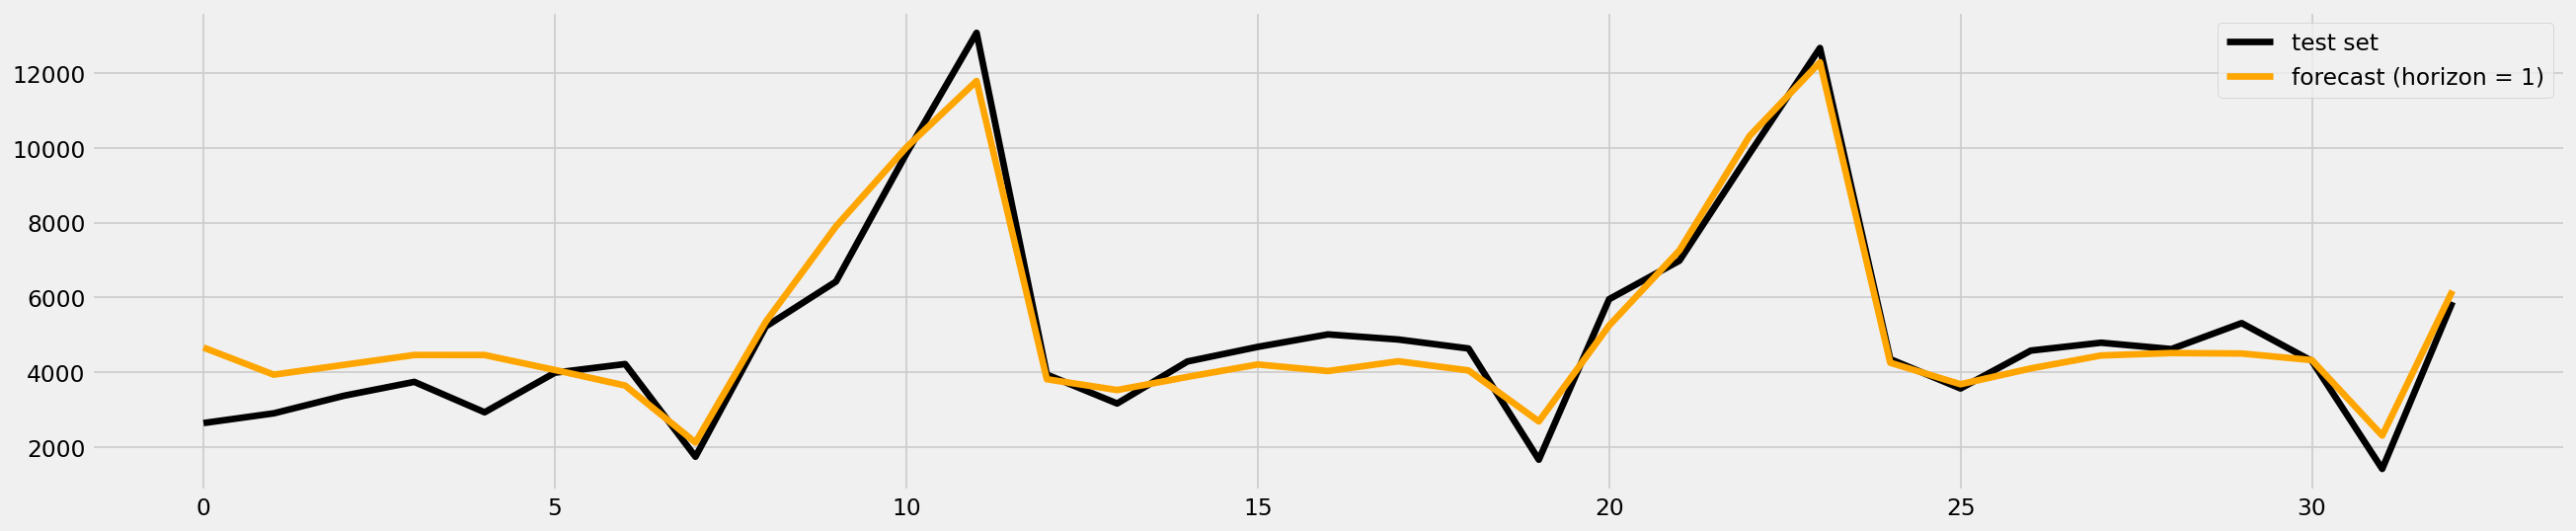

In [48]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

In [132]:
data = pd.read_csv('data/monthly_champagne_sales.csv')
data.Month = pd.to_datetime(data.Month)

for i in range(1, 25):    # Adding lagged values (of target variable) from 1 steps to 24
    data["lag_{}".format(i)] = data.Sales.shift(i)

data["Rolling_12"] = data["Sales"].rolling(window = 12, center=False).mean()
data["Rolling_3"] = data["Sales"].rolling(window = 3, center=False).mean()
data["Rolling_2"] = data["Sales"].rolling(window = 2, center=False).mean()

data['12dayEWM'] = data.Sales.ewm(halflife='12 days', times=pd.DatetimeIndex(data.Month)).mean()
data['3dayEWM'] = data.Sales.ewm(halflife='3 days', times=pd.DatetimeIndex(data.Month)).mean()
data['2dayEWM'] = data.Sales.ewm(halflife='2 days', times=pd.DatetimeIndex(data.Month)).mean()

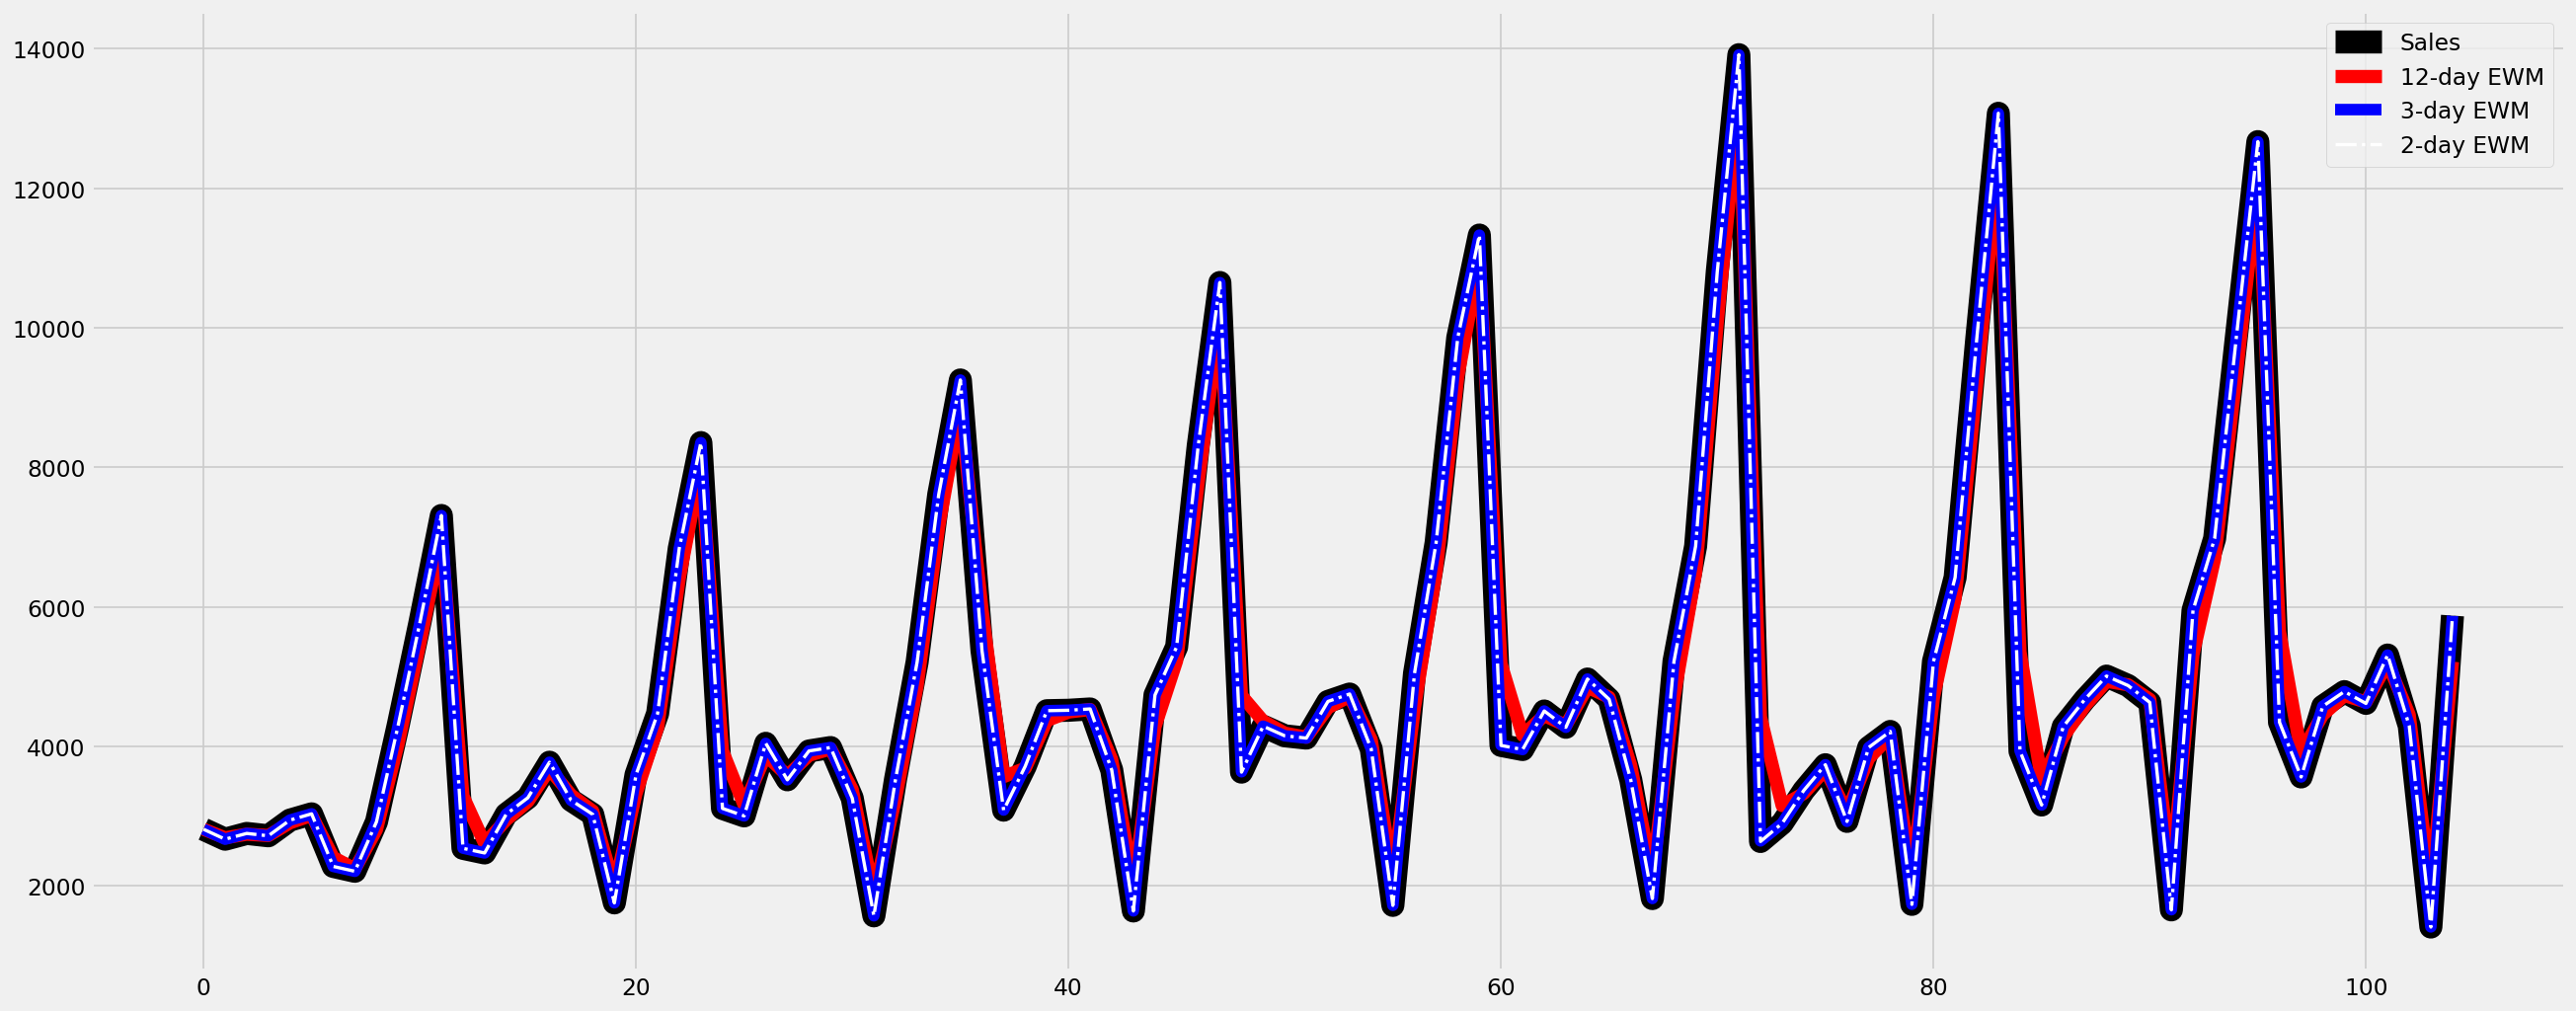

In [158]:
plt.figure(figsize=(24,10))
plt.plot(data['Sales'], 'k', linewidth=14, markersize=12, label='Sales')
plt.plot(data['12dayEWM'],  'r', linewidth=8, markersize=5, label='12-day EWM')
plt.plot(data['3dayEWM'],  'b', linewidth=7, markersize=5, label='3-day EWM')
plt.plot(data['2dayEWM'],  'w-.', linewidth=2, markersize=5, label='2-day EWM')
#data.Sales.ewm(span=5).mean().plot(style='g')
#data.Sales.ewm(com=4/10).mean().plot(style='r')
plt.legend()
plt.show()

In [134]:
df = data.dropna(axis=0).reset_index(drop=True)
df_train, df_test = df[df.Month < '1970-01-01'], df[df.Month >= '1970-01-01']

test_indexes = df_test.index
X = df.drop(['Sales', 'Month'], axis=1)
y = df.Sales

In [135]:
random_forest = RandomForestRegressor(max_depth=5, random_state=0)
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

Mean Absolute Prediction Error MAPE:  0.04951978373967237


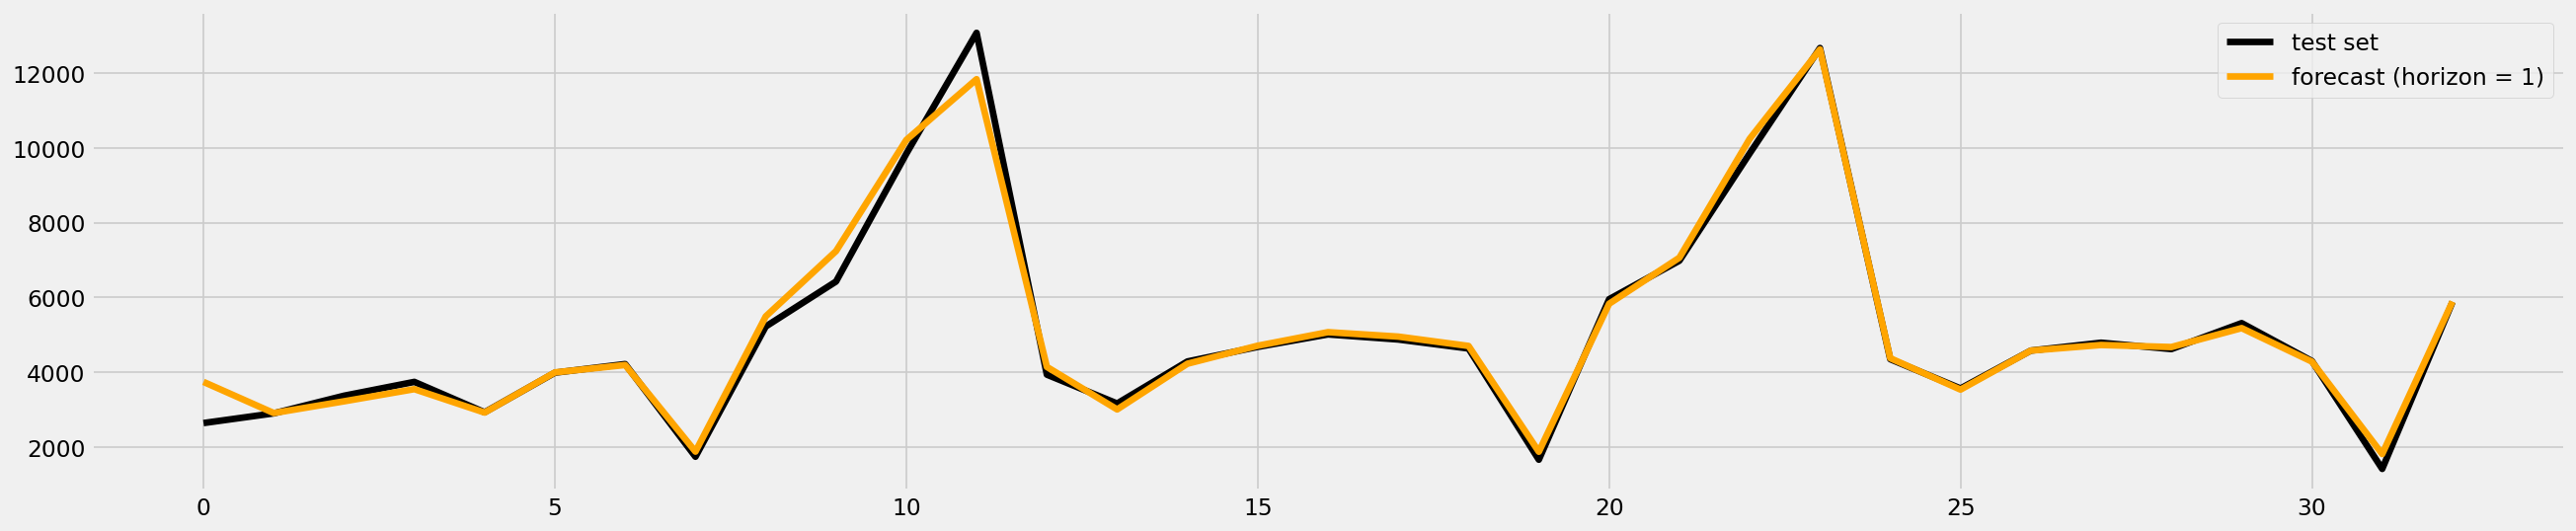

In [136]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

You should see a better MAPE!

In [137]:
print('Mean Absolute Prediction Error MAPE: ', results[2])

Mean Absolute Prediction Error MAPE:  0.04951978373967237


Try to look at the importance of each feature. What do you find?


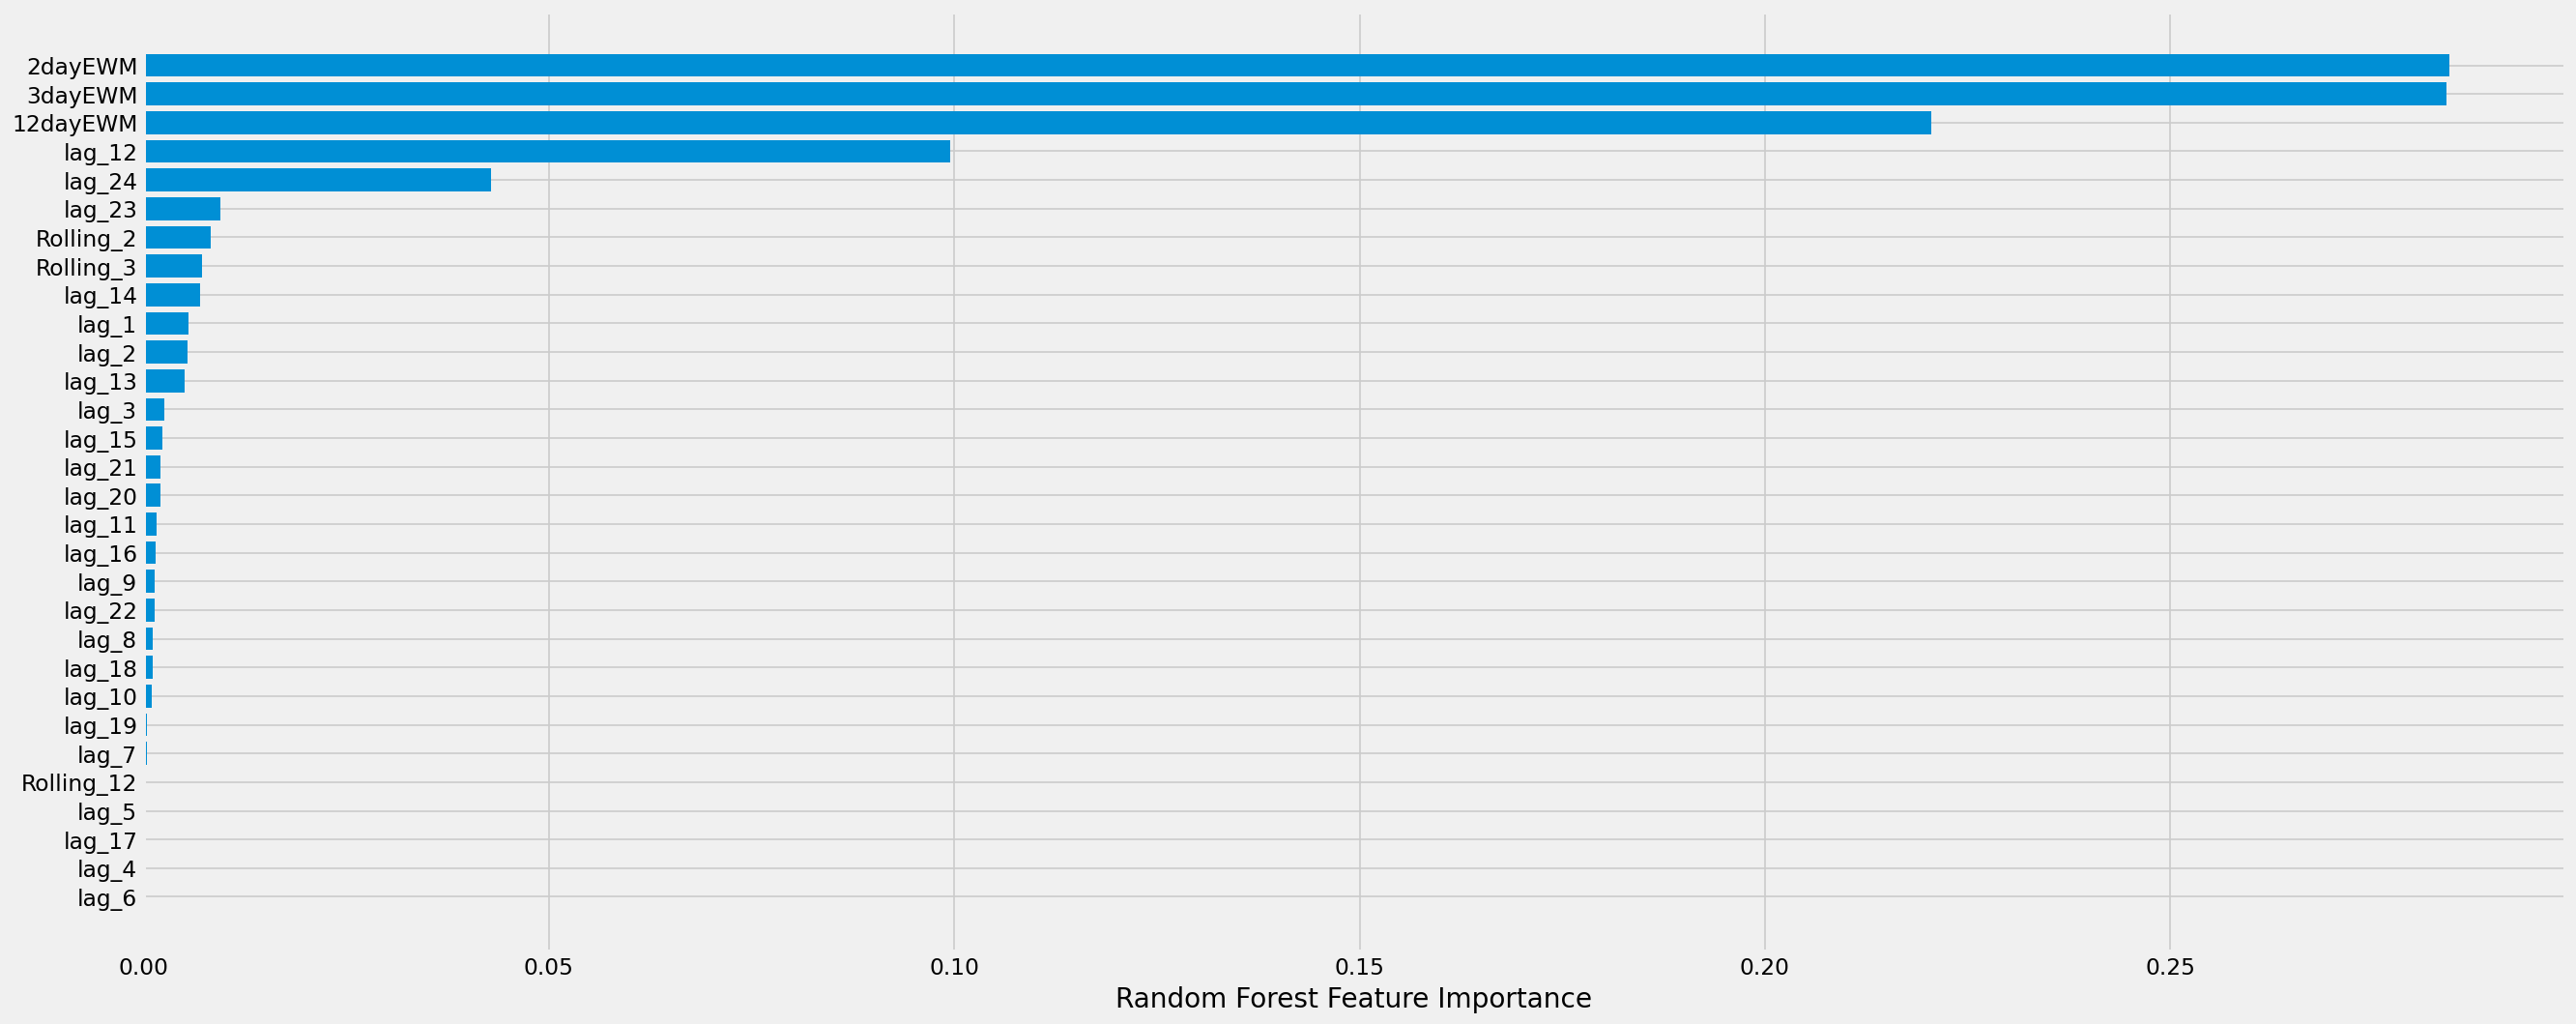

In [142]:
# Basic Feature Importance check

sorted_idx = random_forest.feature_importances_.argsort()
plt.figure(figsize=(24,10))
plt.barh(X.columns[sorted_idx], random_forest.feature_importances_[sorted_idx])
plt.xlabel("\nRandom Forest Feature Importance")
plt.show()

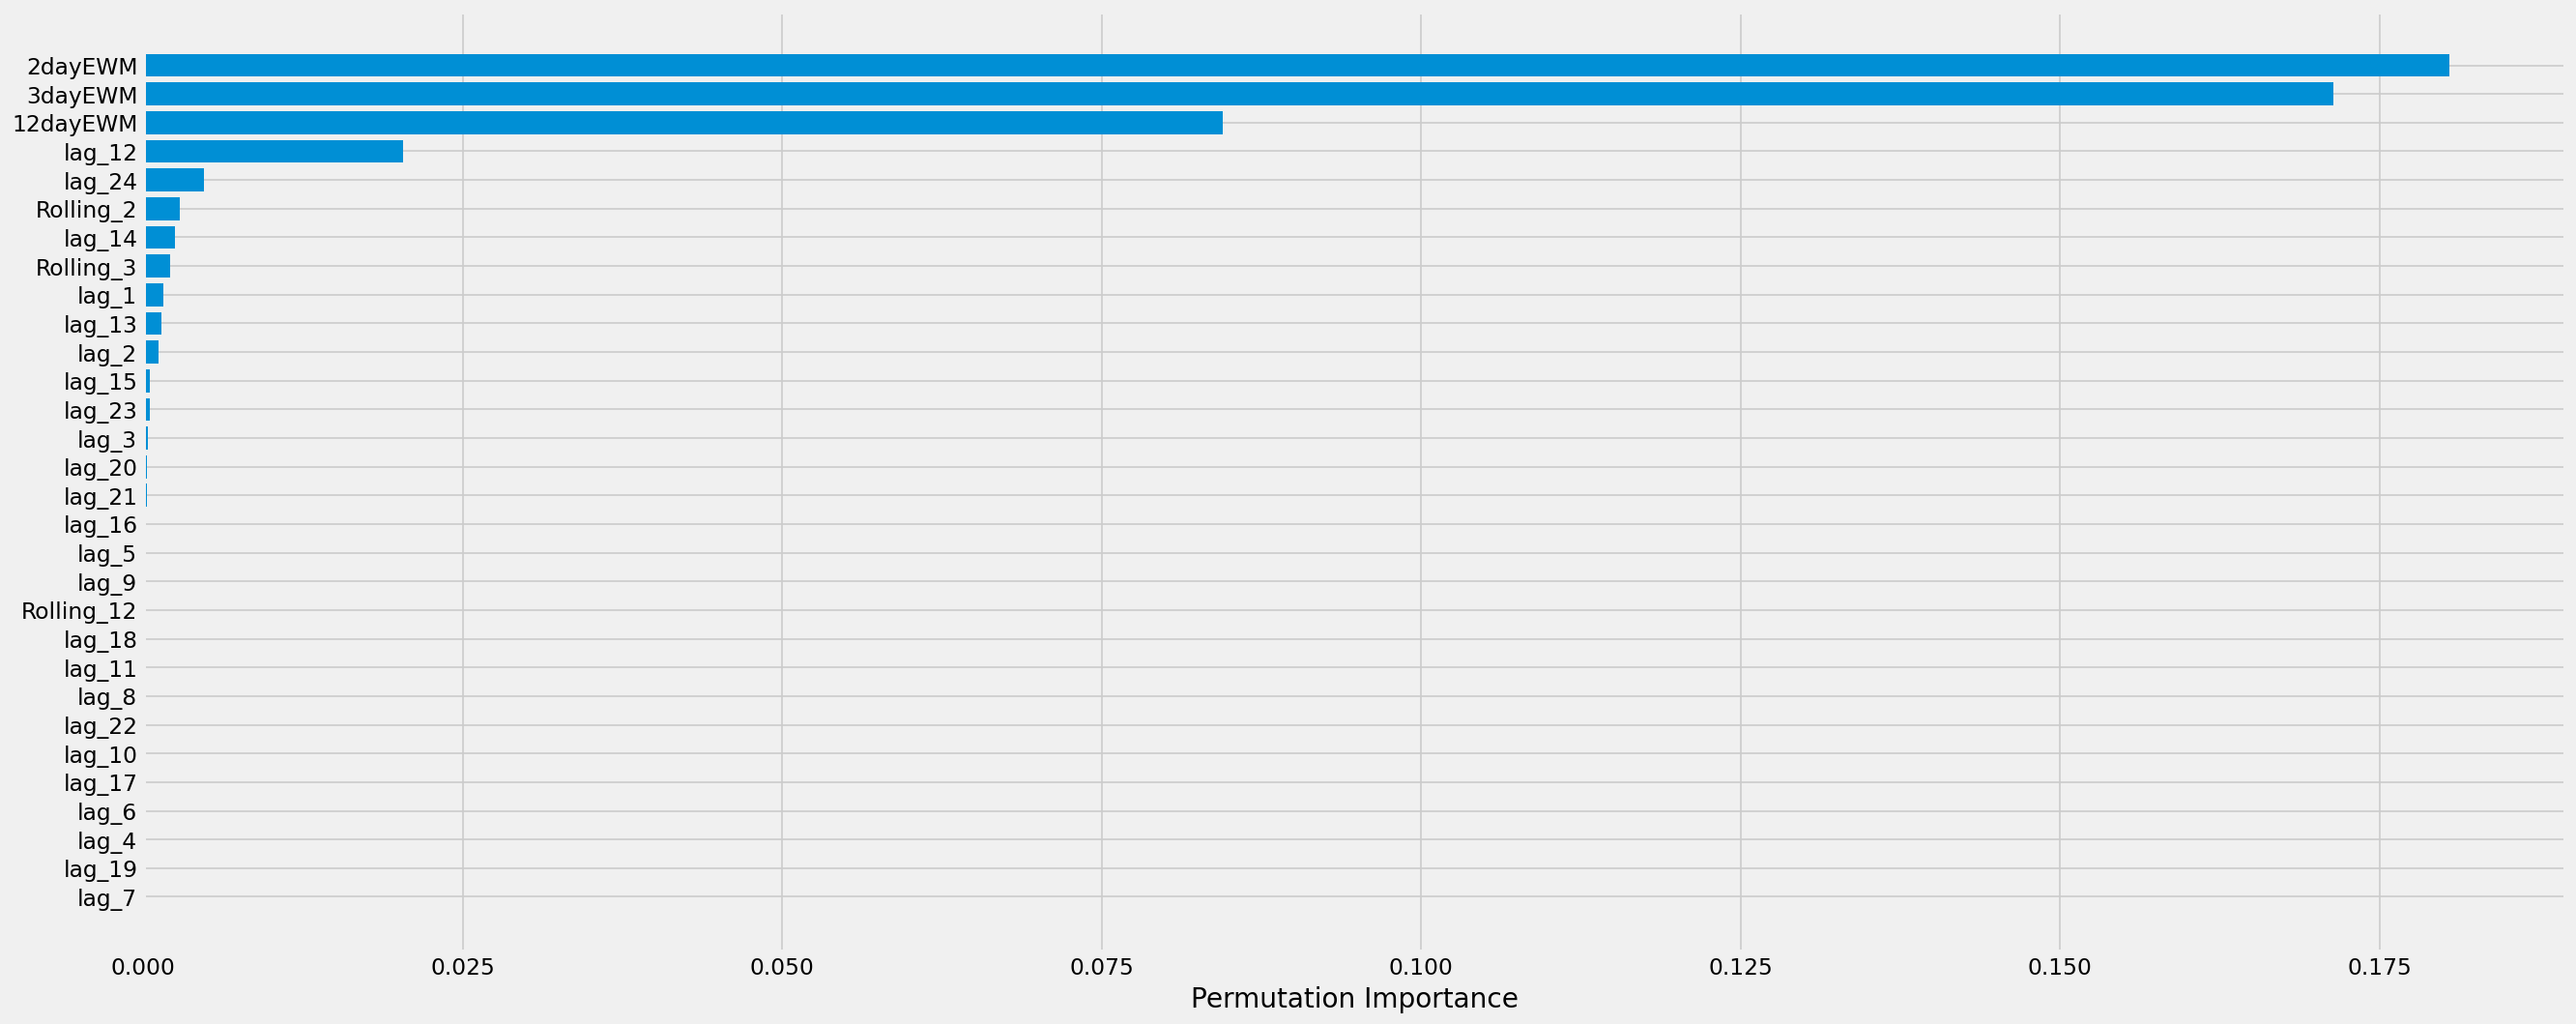

In [145]:
# permuted Feature Importance check
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(random_forest, X.values, y)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(24,10))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("\nPermutation Importance")
plt.show()

### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA